In [1]:
## circstats
def len2(x):
	if type(x) is not type([]):
		if type(x) is not type(array([])):
			return -1
	return len(x)

def phase2(x):
	if not np.isnan(x):
		return phase(x)
	return nan
    
def circdist(angles1,angles2):
    ''' calculates circular distance of angles [rad]'''
    if len2(angles2) < 0:
        if len2(angles1) > 0:
            angles2 = [angles2]*len(angles1)
        else:
            angles2 = [angles2]
            angles1 = [angles1]
        if len2(angles1) < 0:
            angles1 = [angles1]*len(angles2)
    return array(list(map(lambda a1,a2: phase2(np.exp(1j*a1)/np.exp(1j*a2)), angles1,angles2)))

In [2]:
def read_baseline(filename, mode):
    ''' 
    reads in accuracies/std for 1000x mixed labels per timepoint for r² and MSE evaluation
    INPUT:
        filename:       name of file containing 1000x croxxvalidation on mixed labels
    OUTPUT:
        r2_baseline:    previous accuracy, std and current accuracy, std for the mixed labels R² evaluation
        mse_baseline:   previous accuracy, std and current accuracy, std for the mse evaluation turned into MSE accuracy[%]
    
    '''
    file = io.open(filename, "r")
    contents = file.readlines()

    values = [eval(contents[i]) for i in range(len(contents))]

    if mode == 'r2':
        r2_baseline = {'acc_prev':values[0], 'std_prev':values[1], 'acc_curr':values[2], 'std_curr':values[3]}
        return r2_baseline
        
    elif mode =='MSE':
        #values[4] = 100-np.array(values[4])*100/circdist(0, np.pi)[0]**2#np.pi
        #values[5] = np.array(values[5])*100
        #values[6] = 100-np.array(values[6])*100/circdist(0, np.pi)[0]**2#np.pi
        #values[7] = np.array(values[7])*100
        mse_baseline = {'acc_prev':values[4], 'std_prev':values[5], 'acc_curr':values[6], 'std_curr':values[7]}
        return mse_baseline

    return print('ERROR: mode must either be r2 or MSE.')

## Load data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from scipy.stats import *
from cmath import phase
from numpy import array
from scipy.sparse import csr_matrix
import urllib
import glob
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
import statsmodels.formula.api as sf
from sklearn import metrics
from random import randint
import math
import scipy
import io


#!wget https://github.com/MelanieTschiersch/SmithData/blob/main/Sa191226.mat?raw=true # , Pe180728.mat, Wa180222.mat
#!mv Sa191226.mat?raw=true Sa191226.mat #, Pe180728.mat, Sa191226.mat

#!wget https://github.com/comptelab/distributedWM/blob/main/smith/PFC_PFC/Sa191202.mat # , Pe180728.mat, Wa180222.mat
#!mv Sa191226.mat?raw=true Sa191226.mat #, Pe180728.mat, Sa191226.mat
data={'Sa': [], 'Pe':[], 'Wa':[]}
for m in ["Sa", "Pe", "Wa"]:
    files = np.sort(glob.glob('../Data/%s*.mat' %m))
    for f in files:
#data = loadmat('distributedWM/smith/PFC_PFC/Sa191202.mat')#Sa191203
        data[m].append(loadmat(f))
        print(f)
    #files_web = np.sort(glob.glob('%s*.mat' %m))
    #for f in files_web:
    #    data[m].append(loadmat(f))#, Pe180728.mat, Wa180222.mat, Sa191226.mat


../Data/Sa191202.mat
../Data/Sa191203.mat
../Data/Sa191226.mat
../Data/Pe180728.mat
../Data/Wa180222.mat


In [4]:
left_idx = {'Sa': [[] for i in range(len(data['Sa']))], 'Pe':[[] for i in range(len(data['Pe']))], 'Wa':[[] for i in range(len(data['Wa']))]}
right_idx = {'Sa': [[] for i in range(len(data['Sa']))], 'Pe':[[] for i in range(len(data['Pe']))], 'Wa':[[] for i in range(len(data['Wa']))]}
for m in ["Sa", "Pe", "Wa"]:
    for n in range(len(data[m])):
        left_idx[m][n] = data[m][n]['left_idx']
        right_idx[m][n] = data[m][n]['right_idx']


In [5]:
dataset=[]
monkey=[]
session=[]
for m in ['Sa','Pe','Wa']:
    for n in range(len(data[m])):
        for line in data[m][n]['dat'][0]:
            dataset.append([row if not isinstance(row, np.ndarray) else row.flat[0] if len(row[0])==1 else row[0] for row in line])
            monkey.append(m)
            session.append(n)


columns = ['trial_id','sp_train', 'outcome', 'timing', 'targ_xy', 'targ_angle', 'saccade_xy', 'saccade_angle']

df_dat = pd.DataFrame(dataset, columns=columns)
df_dat['monkey'] = monkey
df_dat['session'] = session

In [6]:
taskperiods = ['fix', 'targ_on', 'targ_off', 'go_cue', 'saccade', 'reward']
for i in range(len(taskperiods)):
    df_dat[taskperiods[i]] = [line[i].flat[0] for line in df_dat['timing']]
del df_dat['timing']

In [7]:
df_dat['trial_end'] = [df_dat['sp_train'][n].shape[1] for n in range(len(df_dat['sp_train']))]

In [8]:
x_start=[]
x_label=[]
clockw=[]

for n in range(len(df_dat['targ_on'])):
    x_start.append([])
    x_label.append([])
    x = csr_matrix(df_dat['sp_train'][n])
    x_start[n] = np.sum(x[:,df_dat['targ_on'][n]:df_dat['targ_off'][n]].toarray(), axis=1)
    x_label[n] = df_dat['targ_angle'][n]
    if circdist(df_dat['targ_angle'][n]*np.pi/180, df_dat['saccade_angle'][n]*np.pi/180)<=0:
        clockw.append('CW') 
    else:
        clockw.append('CCW') 

df_dat['n_cue'] = x_start # all neurons during time of cue
df_dat['clockw'] = clockw
df_dat.head()

,trial_id,sp_train,outcome,targ_xy,targ_angle,saccade_xy,saccade_angle,monkey,session,fix,targ_on,targ_off,go_cue,saccade,reward,trial_end,n_cue,clockw
0,1,"(40, 0)\t1.0\n (73, 0)\t1.0\n (51, 1)\t1.0...",CORRECT,"[-81.32022937758153, -196.32440065864844]",247.5,"[-94.13180712732776, -171.71289550644755]",241.268755,Sa,0,1,236,656,3706,3904,4036,4825,"[2.0, 5.0, 37.0, 10.0, 11.0, 5.0, 3.0, 25.0, 1...",CCW
1,2,"(35, 1)\t1.0\n (7, 2)\t1.0\n (12, 2)\t1.0\...",CORRECT,"[196.32440065864844, -81.32022937758153]",337.5,"[181.59180019708026, -74.49810902444511]",337.694090,Sa,0,1,239,659,2189,2391,2519,3288,"[2.0, 12.0, 29.0, 1.0, 8.0, 8.0, 4.0, 26.0, 1....",CW
2,4,"(21, 0)\t1.0\n (68, 0)\t1.0\n (87, 0)\t1.0...",CORRECT,"[-81.32022937758157, 196.32440065864844]",112.5,"[-96.76686414165835, 177.17716528930353]",118.641548,Sa,0,1,239,659,2789,2983,3109,3879,"[1.0, 7.0, 30.0, 2.0, 16.0, 9.0, 9.0, 15.0, 0....",CW
3,5,"(6, 0)\t1.0\n (61, 0)\t1.0\n (71, 0)\t1.0\...",CORRECT,"[-196.32440065864844, 81.3202293775816]",157.5,"[-199.06297645572684, 46.04101453015077]",166.977129,Sa,0,1,239,659,2589,2750,2879,3650,"[2.0, 4.0, 13.0, 6.0, 15.0, 9.0, 2.0, 17.0, 0....",CW
4,6,"(79, 0)\t1.0\n (126, 0)\t1.0\n (1, 2)\t1.0...",CORRECT,"[-196.32440065864844, -81.32022937758155]",202.5,"[-206.4608640384042, -108.05421218627242]",207.625947,Sa,0,1,241,660,3090,3276,3411,4179,"[2.0, 4.0, 15.0, 5.0, 18.0, 17.0, 4.0, 24.0, 0...",CW


# Neural Analysis

## USING neurons during cue

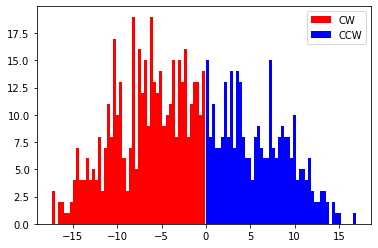

In [15]:
hel = df_dat.loc[(df_dat['monkey']=='Sa') & (df_dat['session']==0)]
err_CW = circdist(hel.loc[(df_dat['clockw']=='CW')]['targ_angle'].values*np.pi/180, hel.loc[(df_dat['clockw']=='CW')]['saccade_angle'].values*np.pi/180)*180/np.pi
err_CCW = circdist(hel.loc[(df_dat['clockw']=='CCW')]['targ_angle'].values*np.pi/180, hel.loc[(df_dat['clockw']=='CCW')]['saccade_angle'].values*np.pi/180)*180/np.pi

plt.figure()
plt.hist(err_CW, color='red', bins=50,label='CW')
plt.hist(err_CCW, color='blue', bins=50 ,label='CCW')
plt.legend()
plt.show()


## Receptive fields

In [16]:
# want to look at one neuron over all target angles
# data of one monkey; mean across trials if target angle same for each neuron

# get all indices of trials for monkey Sa that have the same target
group_Sa = df_dat.loc[(df_dat['monkey']=='Sa') & (df_dat['session']==0)].groupby(['targ_angle'])

# get mean neuron spikecount vector for each target position, average across trials
receptive_fields = []
for k in list(group_Sa.groups):# for all groups
    print(k)
    receptive_fields.append(np.mean(group_Sa.get_group(k)['n_cue'].values))

22.5
67.5
112.5
157.5
202.5
247.5
292.5
337.5


#### plot receptive fields of some neurons for monkey Sa, session0

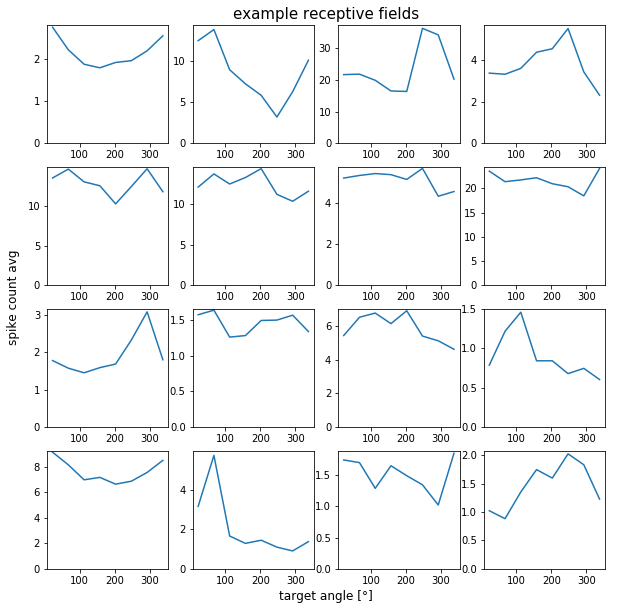

In [17]:
x = np.linspace(min(group_Sa.groups), max(group_Sa.groups), len(group_Sa.groups))

fig, ax = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,10))
for i in range(0,16):
    shift=0
    plt.subplot(4,4,i+1)
    plt.plot(x,[receptive_fields[n][shift+i] for n in range(len(receptive_fields))])
    plt.xticks([100,200,300],[100,200,300])
    plt.ylim(0, plt.ylim()[1])
    #plt.title('neuron '+str(shift+i))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.title('example receptive fields', fontsize=15)
plt.xlabel('target angle [°]', fontsize=12)
plt.ylabel('spike count avg', fontsize=12)
#plt.savefig('../Figures/ExampleReceptiveFields_Sa0.png',dpi=100)
plt.show()

# Multinomial regression

### split data into time periods, time bins within each period (delay variances)

In [9]:
#only use Sa, sess0
df_Sa0 = df_dat.loc[(df_dat['monkey']=='Sa') & (df_dat['session']==2)]

# make spike trains into csr matrix for each trial
df_Sa0.loc[:,'n_mat'] = [csr_matrix(df_Sa0.loc[n,'sp_train']) for n in df_Sa0['sp_train'].index]


# determine border points between different time periods, until beginning of delay
bins = 200 # TODO! 250ms in Li2021
timings = ['fix','targ_on','targ_off', 'go_cue']#,'saccade', 'reward', 'trial_end']# discrete timings
help = 0
borders=[]
# borders 
for period in range(len(timings)):
    #help += int(min([(df_Sa0.loc[n, timings[period+1]]-df_Sa0.loc[n, timings[period]]) for n in range(len(df_Sa0))])/bins)
    #borders.append(help)
    borders.append(int(min(df_dat[timings[period]]/bins)))
print(borders)

timings = ['fix','targ_on','targ_off', 'go_cue']#,'saccade', 'reward', 'trial_end']# discrete timings
help = 0
borders=[]
# borders 
for period in range(len(timings)):
    #help += int(min([(df_Sa0.loc[n, timings[period+1]]-df_Sa0.loc[n, timings[period]]) for n in range(len(df_Sa0))])/bins)
    #borders.append(help)
    borders.append(int(min(df_dat[timings[period]]/bins)))
print(borders)

# determine border points INDIVID trials between different time periods, for end of delay
timings2 = ['go_cue','saccade', 'reward', 'trial_end']
t_borders2 = ['delay_start','delay_end','saccade', 'reward', 'trial_end', 'end_start', 'end']#
borders2={'delay_start': [], 'delay_end': [], 'saccade': [], 'reward':[], 'trial_end':[], 'end_start':[], 'end':[]}##np.zeros((len(timings2)+1, len(df_Sa0)))
for i,m in enumerate(borders2.keys()):
    if i==0:
        #create shifted "start" of delay
        borders2[m] = ((df_Sa0['go_cue'].values)/bins - min(((df_Sa0['go_cue'].values-df_Sa0['targ_off'].values)/bins))).astype(int)#
    elif i ==1:
        # delay end
        borders2[m] = ((df_Sa0['go_cue'].values)/bins).astype(int)
        #np.array([int(df_Sa0.loc[n,timings2[0]]/bins)-(borders[-1]) for n in range(len(df_Sa0))])
    elif m =='end_start':
        # shifted "start" of trial end : complete end of trial - minimum(trial_end-reward)
        borders2[m] = [int(df_Sa0.loc[n,'trial_end']/bins)-int(min((df_Sa0.loc[:,'trial_end']-df_Sa0.loc[:,'reward'])/bins)) for n in df_Sa0.index]#
    elif m == 'end':
        borders2[m] = [int(df_Sa0.loc[n,'trial_end']/bins) for n in df_Sa0.index]
    else:
    # create end delay, saccade start, reward start, trial_end through using minimum distance between periods, adding to delay_end, saccade_end,..
        borders2[m] = np.array(borders2[t_borders2[i-1]]) + min([int((df_Sa0.loc[n,timings2[i-1]]-df_Sa0.loc[n,timings2[i-2]])/bins) for n in df_Sa0.index])
    #print(min([int((df_Sa0.loc[n,timings2[period]]- df_Sa0.loc[n,timings2[period-1]])/bins) for n in range(len(df_Sa0))]))
    #np.array(min([int((df_Sa0.loc[n,timings2[period]]- df_Sa0.loc[n,timings2[period-1]]))/bins for n in range(len(df_Sa0))]))

print(borders2)
## add shift between trial short end and trial long start
borders.append(borders[-1]+min(np.array(borders2['trial_end'])- np.array(borders2['delay_start'])))

# add saccade for response period
#borders.append(borders[-1]+min(np.array(borders2['saccade'])- np.array(borders2['delay_end'])))

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


[0, 1, 3, 10]
[0, 1, 3, 10]
{'delay_start': array([4, 5, 5, ..., 5, 3, 3]), 'delay_end': array([11, 12, 12, ..., 12, 11, 11]), 'saccade': array([11, 12, 12, ..., 12, 11, 11]), 'reward': array([11, 12, 12, ..., 12, 11, 11]), 'trial_end': array([14, 15, 15, ..., 15, 14, 14]), 'end_start': [13, 14, 15, 13, 13, 14, 13, 13, 15, 13, 14, 15, 14, 13, 15, 15, 14, 13, 13, 14, 13, 14, 14, 15, 15, 13, 13, 14, 14, 13, 15, 13, 13, 13, 14, 14, 14, 12, 12, 13, 14, 15, 14, 13, 15, 14, 12, 14, 14, 12, 14, 13, 14, 12, 13, 13, 14, 14, 14, 14, 15, 12, 14, 15, 13, 12, 13, 14, 13, 15, 15, 14, 14, 14, 15, 13, 13, 14, 14, 12, 15, 13, 13, 14, 14, 14, 14, 12, 14, 13, 13, 15, 13, 13, 15, 14, 13, 12, 13, 13, 13, 12, 14, 14, 15, 14, 12, 14, 12, 14, 13, 14, 15, 12, 14, 14, 15, 15, 13, 14, 12, 12, 13, 14, 15, 14, 13, 14, 15, 13, 14, 13, 14, 13, 13, 12, 13, 14, 14, 15, 14, 15, 14, 12, 14, 13, 14, 15, 13, 14, 13, 15, 13, 13, 12, 15, 14, 12, 13, 12, 14, 15, 13, 14, 12, 14, 13, 12, 12, 13, 14, 13, 13, 12, 15, 13, 14, 13,

In [10]:
bin_sp_trials=[]
period_spikes=[]
for trial in df_Sa0.index:# for all trials
    binned_spikes = []
    for period in range(len(timings[:-1])):# for all discrete timings
        for t in range(borders[period+1]-borders[period]): # for all time bins in discrete timings:           
            # sum the matrix of neurons at timings in bin
            binned_spikes.append(np.sum(df_Sa0.loc[trial, 'n_mat'][:,df_Sa0.loc[trial,timings[period]]+t*bins:df_Sa0.loc[trial,timings[period]]+t*bins+bins].toarray(), axis=1))
        #print(t)
    #print(len(binned_spikes[0]))
    bin_sp_trials.append(binned_spikes)


In [11]:
# for first cut (different delay lengths)
bin_sp_trials_pastdelay=[]
period_spikes=[]
for idx, trial in enumerate(df_Sa0.index):# for all trials
    binned_spikes = []
    number_bins=[]
    for period in range(len(borders2)-1):# for all time periods until trial_end
        if period<4:
            number_bins.append(borders2[t_borders2[period+1]][0]-borders2[t_borders2[period]][0])
            for t in range(borders2[t_borders2[period+1]][0]-borders2[t_borders2[period]][0]): # for number of time bins in discrete timings:           
                # sum the matrix of neurons at timings in bin
                binned_spikes.append(np.sum(df_Sa0.loc[trial, 'n_mat'][:,borders2[t_borders2[period]][idx]*bins+t*bins:borders2[t_borders2[period]][idx]*bins+t*bins+bins].toarray(), axis=1))
        elif period>4:
            number_bins.append(borders2[t_borders2[period+1]][0]-borders2[t_borders2[period]][0])
            for t in range(borders2[t_borders2[period+1]][0]-borders2[t_borders2[period]][0]): # for number of time bins in discrete timings:           
                # sum the matrix of neurons at timings in bin
                binned_spikes.append(np.sum(df_Sa0.loc[trial, 'n_mat'][:,borders2[t_borders2[period]][idx]*bins+t*bins:borders2[t_borders2[period]][idx]*bins+t*bins+bins].toarray(), axis=1))

    #print(len(binned_spikes[0]))
    bin_sp_trials_pastdelay.append(binned_spikes)

bin_sp_complete = np.append(bin_sp_trials,bin_sp_trials_pastdelay, axis=1)

# add to dataframe
bin_s=[]
for trial,idx in enumerate(df_Sa0.index):
    bin_s.append(bin_sp_complete[trial])
df_Sa0['bin_sp']=bin_s

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
borders_full=[]
borders_full = np.append(borders[:-1],borders[-2]+number_bins[0])
for i in range(1,len(number_bins)):
    borders_full = np.append(borders_full,borders_full[-1]+number_bins[i])
#borders_full = np.append(borders_full,borders_full[-1]+borders2['reward'][0]-borders2['saccade'][0])
#borders_full = np.append(borders_full,borders_full[-1]+borders2['trial_end'][0]-borders2['reward'][0])
#borders_full = np.append(borders_full,borders_full[-1]+borders2['end'][0]-borders2['trial_end'][0])

borders_pastdelay = borders_full[len(borders):]

## Decoding accuracies across time (train, test across time)

In [357]:
# make X, y vector
# y is fixed only X changes based on time in trial
y = df_Sa0['targ_angle'].astype(int)

acc_bias_full = []
std_bias_full = []
for delta_t_train in range(len(bin_sp_complete[0])):# for each time bin
    # create training dataset: columns=neurons, rows=trials within specified time bin(in period)
    X_full = pd.DataFrame([bin_sp_complete[n][delta_t_train] for n in range(len(bin_sp_complete))])

    # Crossvalidation
    acc_crosscorr_full=[]
    for k in range(0,10):# k=10 as in Barbosa2020
        #train test split
        X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y, test_size = 0.20)# train in slow loop

        # make multinomial regression fit
        model_full = LogisticRegression(random_state=0, multi_class='multinomial',\
                                        penalty='none', solver='newton-cg').fit(X_train_full, y_train_full)

        # make linear regeression fit
        #model 1 = LinearRegression().fit(X_train, y_train)# 
        preds_full = model_full.predict(X_test_full)

        acc_crosscorr_full.append(metrics.accuracy_score(y_test_full, preds_full))
        #value = model1.score(X_test, y_test)
        #acc_crosscorr.append(value)
    acc_bias_full.append(np.mean(acc_crosscorr_full))
    std_bias_full.append(np.std(acc_crosscorr_full))


KeyboardInterrupt: 

In [ ]:
borders_pastdelay

In [71]:
# plot only trained/tested in same time bin
x = np.linspace(0,len(acc_bias_full[:borders[-1]])*bins, len(acc_bias_full[:borders[-1]]))
x2 = np.linspace(0,len(acc_bias_full[borders[-1]:])*bins, len(acc_bias_full[borders[-1]:]))
labels = np.array(['0', 'St', 'St_E', 'D', 'D','S','R', 'E'])

f, (ax1, ax2) = plt.subplots(1, 2,sharey=True, figsize=(8,5))
plt.subplots_adjust(wspace=0.05)
ax1.plot(x,acc_bias_full[:borders[-1]], color='k')
# errorbar
ax1.fill_between(x, acc_bias_full[:borders[-1]]-0.5*np.array(std_bias_full[:borders[-1]]), acc_bias_full[:borders[-1]]+0.5*np.array(std_bias_full[:borders[-1]]), color='k', alpha=0.2)
for period in range(len(borders)):
    ax1.axvline(borders[period]*bins, *ax1.get_xlim(), color='grey',dashes=[4,2])
ax1.set_xticks(bins*np.array(borders))
ax1.set_xticklabels(labels[:len(borders)], fontsize=12)
#ax1.set_yticklabels(fontsize=12)
ax1.set_xlabel('start aligned', fontsize=14)
ax1.set_ylabel('avg decoding acc (k=10)', fontsize=14)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
#plt.title('Decoding in same time bin as train', fontsize=14)

ax2.plot(x2,acc_bias_full[borders[-1]:], color='k')
figure = plt.gca()
y_axis = figure.axes.get_yaxis()
y_axis.set_visible(False)
# errorbar
ax2.fill_between(x2, acc_bias_full[borders[-1]:]-0.5*np.array(std_bias_full[borders[-1]:]), acc_bias_full[borders[-1]:]+0.5*np.array(std_bias_full[borders[-1]:]), color='k', alpha=0.2)
for period in range(len(borders_pastdelay)):
    ax2.axvline((borders_pastdelay[period]-borders[-1])*bins, *ax2.get_xlim(), color='grey',dashes=[4,2])
ax2.set_xticks(bins*np.array(borders_pastdelay-borders[-1]))
ax2.set_xticklabels(labels[len(borders):], fontsize=12)
#ax2.set_yticklabels(fontsize=12)
ax2.set_xlabel('report aligned', fontsize=14)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.xaxis.set_ticks_position('bottom')

#plt.savefig('../Figures/Neural/BasicTemporalGen/TemporalGeneralisation_TrainTestSame_Sa0.png', dpi=100)

plt.show()

NameError: name 'acc_bias_full' is not defined

## DON'T RUN UNLESS YOU HAVE A LOT OF TIME

### Only short delays

In [ ]:
# make X, y vector
# y is fixed only X changes based on time in trial
y = df_Sa0['targ_angle'].astype(int)
# y = df_Sa0['targ_angle']#


t_gen=[]
temp_gen=[]
std_testLoop = []
acc_testLoop=[]
temp_gen_mat = []
std_temp_gen = []
for delta_t_train in range(len(bin_sp_trials[0])):# for each period ['targ_on', 'targ_off', 'go_cue', 'saccade', 'reward']
    # create training dataset: columns=neurons, rows=trials within specified time bin(in period)
    X1 = pd.DataFrame([[bin_sp_trials[n][delta_t_train][i] for i in range(len(bin_sp_trials[n][delta_t_train]))] for n in range(len(bin_sp_trials))])
    for delta_t_test in range(len(bin_sp_trials[0])):
        # create testing dataset: columns=neurons, rows=trials within specified time bin(in period)
        X2 = pd.DataFrame([[bin_sp_trials[n][delta_t_test][i] for i in range(len(bin_sp_trials[n][delta_t_test]))] for n in range(len(bin_sp_trials))])

        # Crossvalidation
        acc_crosscorr=[]
        for k in range(0,10):# k=10 as in Barbosa2020
            rand_state = randint(0, 10000)# create random state, but replicable within one crossval
            #train test split
            X_train, X_i, y_train, y_i = train_test_split(X1, y, test_size = 0.20, random_state=rand_state)# train in slow loop
            X_i, X_test, y_i, y_test = train_test_split(X2, y, test_size = 0.20, random_state=rand_state)# test in fast loop

            # make multinomial regression fit
            model1 = LogisticRegression(random_state=0, multi_class='multinomial', penalty='none', solver='newton-cg').fit(X_train, y_train)
            # make linear regeression fit
            #model 1 = LinearRegression().fit(X_train, y_train)# 
            preds = model1.predict(X_test)

            acc_crosscorr.append(metrics.accuracy_score(y_test, preds))
            #value = model1.score(X_test, y_test)
            #acc_crosscorr.append(value)
        acc_testLoop.append(np.mean(acc_crosscorr))
        std_testLoop.append(np.std(acc_crosscorr))
    temp_gen_mat.append(acc_testLoop)
    std_temp_gen.append(std_testLoop)


/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:21

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:21

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:21

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:21

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:21

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:21

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:21

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:21

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:21

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:21

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:21

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:21

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:21

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:21

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:21

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:21

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:21

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/sklearn/utils/optimize.py:21

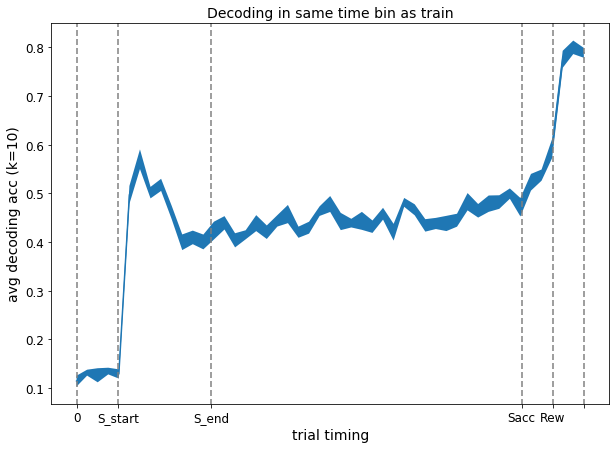

In [63]:
# plot only trained/tested in same time bin
x = np.linspace(0,len(temp_gen_mat)*bins, len(temp_gen_mat))
labels = np.array(['0', 'S_start', 'S_end', 'Sacc', 'Rew', 'end'])

plt.figure(figsize=(10,7))
ax=plt.subplot(111)
plt.plot(x,[temp_gen_mat[i][i] for i in range(len(temp_gen_mat))])
# errorbar
plt.fill_between(x, [temp_gen_mat[i][i] for i in range(len(temp_gen_mat))]-0.5*np.array([std_temp_gen[i][i] for i in range(len(std_temp_gen))]), [temp_gen_mat[i][i] for i in range(len(temp_gen_mat))]+0.5*np.array([std_temp_gen[i][i] for i in range(len(std_temp_gen))]))
for period in range(len(borders)):
    plt.axvline(borders[period]*bins, *ax.get_xlim(), color='grey',dashes=[4,2])
plt.xticks(bins*np.array(borders), labels, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('trial timing', fontsize=14)
plt.ylabel('avg decoding acc (k=10)', fontsize=14)
plt.title('Decoding in same time bin as train', fontsize=14)
#plt.savefig('../Figures/TemporalGeneralisation_TrainTestSame_Sa0.png', dpi=100)
plt.show()

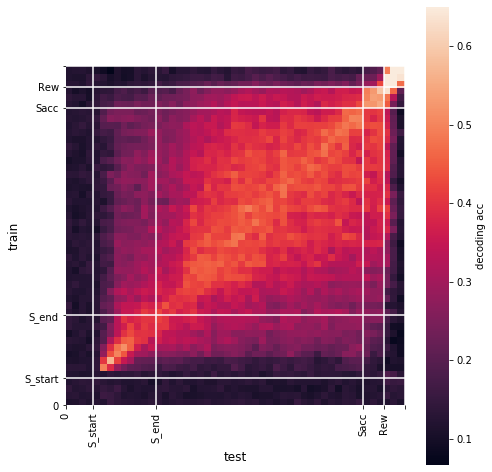

In [64]:
# plot entire train/test matrix

plt.figure(figsize=(7,7))
ax=sns.heatmap(pd.DataFrame(temp_gen_mat),xticklabels=labels,\
               yticklabels=labels, square=True, vmax=0.65, cbar_kws={'label': 'decoding acc'})#, vmin=0.25, vmax=0.65,
ax.hlines(np.array(borders[1:]), *ax.get_xlim(), color='white')
ax.vlines(np.array(borders[1:]), *ax.get_xlim(), color='white')
ax.invert_yaxis()
ax.set_xticks(np.array(borders))
ax.set_yticks(np.array(borders))
plt.xlabel('test', fontsize=12)
plt.ylabel('train', fontsize=12)
plt.tight_layout()
#plt.savefig('../Figures/TemporalGeneralisationMatrix_Sa0.png', dpi=100)
plt.show()

# Serial dependence on target position in fixation period 

#### create dataframe

In [13]:
serial = {'trial_id':[], 'target_prev': [], 'targ_off_prev':[], 'go_cue_prev':[], 'response_prev': [],\
          'delay_prev': [],'bin_sp_prev':[], 'target_curr': [], 'targ_on_curr':[], 'response_curr': [],\
          'delay_curr': [], 'bin_sp_curr':[],  'monkey': [], 'cw':[]}

for trial,idx in enumerate(df_Sa0.index[:-1]):
    if ((df_Sa0['trial_id'][idx]+1) == (df_Sa0['trial_id'][idx+1])):
        serial['trial_id'].append(idx)
        serial['target_prev'].append(df_Sa0['targ_angle'][idx]*np.pi/180)
        serial['targ_off_prev'].append(round(df_Sa0['targ_off'][idx]*np.pi/180, 5))
        serial['go_cue_prev'].append(df_Sa0['go_cue'][idx])
        serial['response_prev'].append(round(df_Sa0['saccade_angle'][idx]*np.pi/180, 5))
        serial['delay_prev'].append(df_Sa0['go_cue'][idx]-df_dat['targ_off'][idx])
        serial['bin_sp_prev'].append(bin_sp_complete[trial])
        serial['target_curr'].append(df_Sa0['targ_angle'][idx+1]*np.pi/180)
        serial['targ_on_curr'].append(df_Sa0['targ_on'][idx+1])
        serial['response_curr'].append(round(df_Sa0['saccade_angle'][idx+1]*np.pi/180, 5))
        serial['delay_curr'].append(df_Sa0['go_cue'][idx+1]-df_Sa0['targ_off'][idx+1]) 
        serial['bin_sp_curr'].append(bin_sp_complete[trial+1])
        serial['monkey'].append(df_Sa0['monkey'][idx])
        serial['cw'].append((df_Sa0['clockw'][idx]=='CW'))
        
df_serial = pd.DataFrame(serial)
#for idx in df_dat.index[:-1]:
#    if ((df_dat['trial_id'][idx]+1) == (df_dat['trial_id'][idx+1])):
#        serial['trial_id'].append(idx)
#        serial['target_prev'].append(round(df_dat['targ_angle'][idx]*np.pi/180, 5))
#        serial['response_prev'].append(round(df_dat['saccade_angle'][idx]*np.pi/180, 5))
#        serial['delay_prev'].append(df_dat['go_cue'][idx]-df_dat['targ_off'][idx])
#        serial['bin_sp_prev'].append(bin_sp_trials[idx])
#        serial['target_curr'].append(round(df_dat['targ_angle'][idx+1]*np.pi/180, 5))
#        serial['targ_on_curr'].append(df_dat['targ_on'][idx+1])
#        serial['response_curr'].append(round(df_dat['saccade_angle'][idx+1]*np.pi/180, 5))
#        serial['delay_curr'].append(df_dat['go_cue'][idx+1]-df_dat['targ_off'][idx+1]) 
#        serial['bin_sp_curr'].append(bin_sp_trials[idx+1])
#        serial['monkey'].append(df_dat['monkey'][idx])



In [14]:
df_serial.head()

,trial_id,target_prev,targ_off_prev,go_cue_prev,response_prev,delay_prev,bin_sp_prev,target_curr,targ_on_curr,response_curr,delay_curr,bin_sp_curr,monkey,cw
0,1528,5.497787,11.06539,2354,5.49639,1720,"[[1.0, 3.0, 7.0, 1.0, 4.0, 3.0, 3.0, 3.0, 5.0,...",3.926991,218,3.97110,1920,"[[2.0, 1.0, 3.0, 0.0, 4.0, 1.0, 1.0, 2.0, 0.0,...",Sa,False
1,1529,3.926991,11.13520,2558,3.97110,1920,"[[2.0, 1.0, 3.0, 0.0, 4.0, 1.0, 1.0, 2.0, 0.0,...",4.712389,222,4.57262,1920,"[[3.0, 4.0, 7.0, 2.0, 3.0, 1.0, 1.0, 8.0, 2.0,...",Sa,True
2,1530,4.712389,11.20501,2562,4.57262,1920,"[[3.0, 4.0, 7.0, 2.0, 3.0, 1.0, 1.0, 8.0, 2.0,...",0.785398,215,0.69901,1520,"[[1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 9.0, 0.0,...",Sa,False
3,1531,0.785398,11.08284,2155,0.69901,1520,"[[1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 9.0, 0.0,...",2.356194,217,2.37639,1619,"[[2.0, 2.0, 7.0, 0.0, 5.0, 2.0, 3.0, 5.0, 2.0,...",Sa,False
4,1533,3.141593,11.17011,2560,3.02242,1920,"[[0.0, 2.0, 5.0, 0.0, 8.0, 1.0, 1.0, 3.0, 0.0,...",0.000000,216,6.26250,1719,"[[1.0, 8.0, 6.0, 1.0, 3.0, 1.0, 2.0, 4.0, 2.0,...",Sa,False


#### get neural data during fixation of current trial

### decode previous target during current fixation period

In [17]:
# make X, y vector
# y is fixed only X changes based on time in trial
y = df_serial['target_prev'].astype(int)

acc_bias_prev = []
std_bias_prev = []
acc_bias_curr = []
std_bias_curr = []
for delta_t_train in range(len(df_serial['bin_sp_prev'][0])):# for each period ['targ_on', 'targ_off', 'go_cue', 'saccade', 'reward']
    # create training dataset: columns=neurons, rows=trials within specified time bin(in period)
    X_prev = pd.DataFrame([df_serial['bin_sp_prev'][n][delta_t_train] for n in range(len(df_serial['bin_sp_prev']))])
    X_curr = pd.DataFrame([df_serial['bin_sp_curr'][n][delta_t_train] for n in range(len(df_serial['bin_sp_curr']))])

    # Crossvalidation
    acc_crosscorr_prev=[]
    acc_crosscorr_curr=[]
    for k in range(0,10):# k=10 as in Barbosa2020
        #train test split
        X_train_prev, X_test_prev, y_train_prev, y_test_prev = train_test_split(X_prev, y, test_size = 0.20)# train in slow loop
        X_train_curr, X_test_curr, y_train_curr, y_test_curr = train_test_split(X_curr, y, test_size = 0.20)# train in slow loop

        # make multinomial regression fit
        model_prev = LogisticRegression(random_state=0, multi_class='multinomial',\
                                        penalty='none', solver='newton-cg').fit(X_train_prev, y_train_prev)
        model_curr = LogisticRegression(random_state=0, multi_class='multinomial',\
                                        penalty='none', solver='newton-cg').fit(X_train_curr, y_train_curr)
        # make linear regeression fit
        #model 1 = LinearRegression().fit(X_train, y_train)# 
        preds_prev = model_prev.predict(X_test_prev)
        preds_curr = model_curr.predict(X_test_curr)

        acc_crosscorr_prev.append(metrics.accuracy_score(y_test_prev, preds_prev))
        acc_crosscorr_curr.append(metrics.accuracy_score(y_test_curr, preds_curr))
        #value = model1.score(X_test, y_test)
        #acc_crosscorr.append(value)
    acc_bias_prev.append(np.mean(acc_crosscorr_prev))
    std_bias_prev.append(np.std(acc_crosscorr_prev))
    acc_bias_curr.append(np.mean(acc_crosscorr_curr))
    std_bias_curr.append(np.std(acc_crosscorr_curr))


### plot reactivations

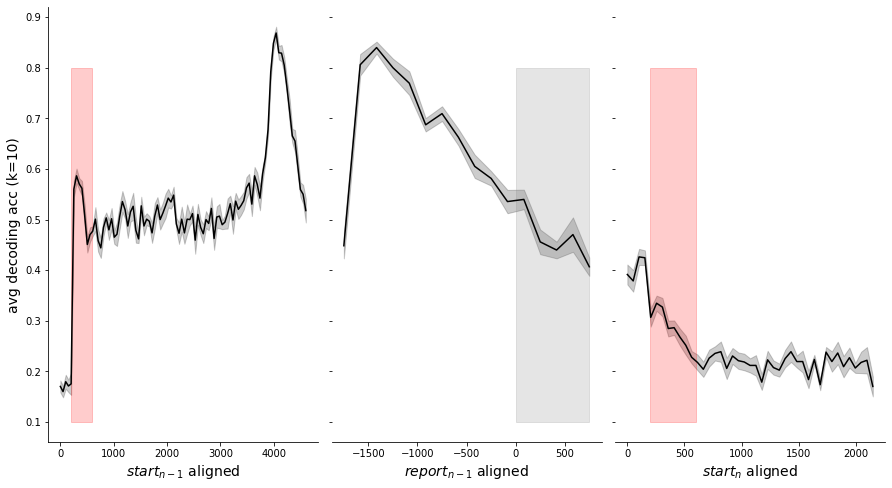

In [18]:
# plot only trained/tested in same time bin
x = np.linspace(0,len(acc_bias_prev[:borders[-1]])*bins, len(acc_bias_prev[:borders[-1]]))
x2 = np.linspace(-(borders_pastdelay[2]-borders[-1])*bins,(borders_pastdelay[3]-borders_pastdelay[2])*bins, len(acc_bias_prev[borders[-1]:]))
x3 = np.linspace(0,len(acc_bias_prev[:borders[-2]])*bins, len(acc_bias_curr[:borders[-2]]))
labels = np.array(['0', '$S_{n-1}$', '$SE_{n-1}$', '$D_{n-1}$', '$D_{n-1}$','$S_{n-1}$','$R_{n-1}$', '$E_{n-1}$'])
labels_curr = np.array(['$0_n$', '$S_n$', '$SE_n$'])

y_high = 0.8
f, (ax1, ax2, ax3) = plt.subplots(1, 3,sharey=True, figsize=(15,8))
plt.subplots_adjust(wspace=0.05)
ax1.plot(x,acc_bias_prev[:borders[-1]], color='k')
# errorbar
ax1.fill_between(x, acc_bias_prev[:borders[-1]]-0.5*np.array(std_bias_prev[:borders[-1]]), acc_bias_prev[:borders[-1]]+0.5*np.array(std_bias_prev[:borders[-1]]), color='k', alpha=0.2)
ax1.fill_between([borders[1]*bins, borders[2]*bins], 0.1,y_high, color='red', alpha=0.2)
#for period in range(len(borders)):
#    ax1.axvline(borders[period]*bins, *ax.get_xlim(), color='grey',dashes=[4,2])
#ax1.set_xticks(bins*np.array(borders))
#ax1.set_xticklabels(labels[:len(borders)], fontsize=12)
#ax1.set_yticklabels(fontsize=12)
ax1.set_xlabel('$start_{n-1}$ aligned', fontsize=14)
ax1.set_ylabel('avg decoding acc (k=10)', fontsize=14)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')

ax2.plot(x2,acc_bias_prev[borders[-1]:], color='k')
# errorbar
ax2.fill_between(x2, acc_bias_prev[borders[-1]:]-0.5*np.array(std_bias_prev[borders[-1]:]), acc_bias_prev[borders[-1]:]+0.5*np.array(std_bias_prev[borders[-1]:]), color='k', alpha=0.2)
ax2.fill_between([0, (borders_pastdelay[3]-borders_pastdelay[2])*bins], 0.1,y_high, color='grey', alpha=0.2)
#for period in range(len(borders_pastdelay)):
#    ax2.axvline((borders_pastdelay[period]-borders[-1])*bins, *ax.get_xlim(), color='grey',dashes=[4,2])
#ax2.set_xticks(bins*np.array(borders_pastdelay-borders[-1]))
#ax2.set_xticklabels(labels[len(borders):], fontsize=12)
#ax2.set_yticklabels(fontsize=12)
ax2.set_xlabel('$report_{n-1}$ aligned', fontsize=14)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.xaxis.set_ticks_position('bottom')

ax3.plot(x3,acc_bias_curr[:borders[-2]], color='k')
ax3.fill_between(x3, acc_bias_curr[:borders[-2]]-0.5*np.array(std_bias_curr[:borders[-2]]), acc_bias_curr[:borders[-2]]+0.5*np.array(std_bias_curr[:borders[-2]]), color='k', alpha=0.2)
ax3.fill_between([borders[1]*bins, borders[2]*bins], 0.1,y_high, color='red', alpha=0.2)
#for period in range(len(borders[:3])):
#    ax3.axvline(borders[period]*bins, *ax.get_ylim(), color='grey',dashes=[4,2])
#ax3.set_xticks(bins*np.array(borders[:3]))
#ax3.set_xticklabels(labels_curr, fontsize=12)
ax3.set_xlabel('$start_n$ aligned', fontsize=14)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.xaxis.set_ticks_position('bottom')

#plt.savefig('../Figures/Neural/SerialBias/TemporalGeneralisation_ReactivationsLow_Wa0.png', dpi=100)
plt.show()

# Continuous decoder

In [15]:
def decode_continuous_prev_cur(dataframe,y, mode):
    # y is fixed only X changes based on time in trial

    acc_prev = []
    std_prev = []
    acc_curr = []
    std_curr = []
    for delta_t_train in range(len(df_serial['bin_sp_prev'][df_serial['bin_sp_prev'].index[0]])):# for each period ['targ_on', 'targ_off', 'go_cue', 'saccade', 'reward']
        # create training dataset: columns=neurons, rows=trials for previous/current trials
        X_prev = pd.DataFrame([dataframe['bin_sp_prev'][n][delta_t_train] for n in dataframe['bin_sp_prev'].index])
        X_curr = pd.DataFrame([dataframe['bin_sp_curr'][n][delta_t_train] for n in dataframe['bin_sp_curr'].index])
        
        # Crossvalidation
        acc_crosscorr_prev=[]
        acc_crosscorr_curr=[]
        for k in range(0,10):# k=10 as in Barbosa2020
            #train test split
            rand_state = randint(0,10000)# to get the same split for previous, current
            X_train_prev ,X_test_prev ,y_train, y_test = train_test_split(X_prev, y, test_size = 0.20, random_state = rand_state)
            X_train_curr ,X_test_curr ,y_train, y_test = train_test_split(X_curr, y, test_size = 0.20, random_state = rand_state)
            
            # determine labels (sine, cosine)
            y_train_cos = np.cos(y_train)
            y_train_sin = np.sin(y_train)
            #y_test_cos = np.cos(y_test)

            # make linear regression fit for sine/cosine for prev/current trial
            model_prev_cos = LinearRegression().fit(X_train_prev, y_train_cos)
            model_prev_sin = LinearRegression().fit(X_train_prev, y_train_sin)
            model_curr_cos = LinearRegression().fit(X_train_curr, y_train_cos)
            model_curr_sin = LinearRegression().fit(X_train_curr, y_train_sin)

            # make predictions of models
            preds_prev_cos = model_prev_cos.predict(X_test_prev)
            preds_prev_sin = model_prev_sin.predict(X_test_prev)
            preds_curr_cos = model_curr_cos.predict(X_test_curr)
            preds_curr_sin = model_curr_sin.predict(X_test_curr)

            #preds_prev_cos[np.where(preds_prev_cos>1)]=1
            #preds_prev_cos[np.where(preds_prev_cos<-1)]=-1
            #preds_prev_sin[np.where(preds_prev_sin>1)]=1
            #preds_prev_sin[np.where(preds_prev_sin<-1)]=-1

            preds_prev = [math.atan2(preds_prev_sin[n],preds_prev_cos[n]) for n in range(len(preds_prev_sin))]
            preds_curr = [math.atan2(preds_curr_sin[n],preds_curr_cos[n]) for n in range(len(preds_prev_sin))]

            # R squared value
            if mode == 'r2':
                acc_crosscorr_prev.append(metrics.r2_score(preds_prev, y_test))
                acc_crosscorr_curr.append(metrics.r2_score(preds_curr, y_test))
            elif mode == 'MSE':
                #acc_crosscorr_prev.append(np.mean(abs(circdist(preds_prev, y_test))))
                #acc_crosscorr_curr.append(np.mean(abs(circdist(preds_curr, y_test))))
                acc_crosscorr_prev.append(np.mean(circdist(preds_prev, y_test)**2))
                acc_crosscorr_curr.append(np.mean(circdist(preds_curr, y_test)**2))
            else:
                print('Mode needs to be either:\n'+'r2 for evaluation with R² metric \n'+\
                      'or\nMSE for evaluation with mean-squared error.')
                return
            

        acc_prev.append(np.mean(acc_crosscorr_prev))
        std_prev.append(np.std(acc_crosscorr_prev))
        acc_curr.append(np.mean(acc_crosscorr_curr))
        std_curr.append(np.std(acc_crosscorr_curr))
    return acc_prev, std_prev, acc_curr, std_curr


### plot reactivations during current trial

In [16]:
def plot_reactivations(acc_bias_prev, std_bias_prev, acc_bias_curr, std_bias_curr, borders, borders_pastdelay, mode, baseline):
    # plot only trained/tested in same time bin
    if mode =='MSE':
        acc_bias_prev = np.array(acc_bias_prev)*-1
        std_bias_prev = std_bias_prev
        acc_bias_curr = np.array(acc_bias_curr)*-1
        std_bias_curr = std_bias_curr
        baseline['acc_prev'] = np.array(baseline['acc_prev'])*-1
        baseline['acc_curr'] = np.array(baseline['acc_curr'])*-1
        #acc_bias_prev = 100-np.array(acc_bias_prev)*100/circdist(0, np.pi)[0]**2#np.pi
        #std_bias_prev = np.array(std_bias_prev)*100
        #acc_bias_curr = 100-np.array(acc_bias_curr)*100/circdist(0, np.pi)[0]**2#np.pi
        #std_bias_curr = np.array(std_bias_curr)*100
    elif mode=='r2':
        acc_bias_prev = acc_bias_prev
    else:
        print('Mode needs to be either:\n'+'r2 for evaluation with R² metric\n'+\
                      'or\nMSE for evaluation with mean-squared error.')
    
    # colors
    c_base = 'grey'
    c_acc = 'darkred'
    
    x = np.linspace(0,len(acc_bias_prev[:borders[-2]])*bins, len(acc_bias_prev[:borders[-2]]))
    x2 = np.linspace(-(borders_pastdelay[2]-borders[-2])*bins,(borders_pastdelay[3]-borders_pastdelay[2])*bins, len(acc_bias_prev[borders[-2]:borders[-1]]))
    x3 = np.linspace(-(len(acc_bias_prev[borders[-1]:]))*bins,0, len(acc_bias_prev[borders[-1]:]))
    x4 = np.linspace(0,len(acc_bias_prev[:borders[-3]])*bins, len(acc_bias_curr[:borders[-3]]))
    labels = np.array(['0', '$S_{n-1}$', '$SE_{n-1}$', '$D_{n-1}$', '$D_{n-1}$','$S_{n-1}$','$R_{n-1}$', '$E_{n-1}$'])
    labels_curr = np.array(['$0_n$', '$S_n$', '$SE_n$'])

    y_low=-1.1
    y_high = 0.8
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,sharey=True, figsize=(18,8))
    plt.subplots_adjust(wspace=0.05)
    ax1.plot(x,acc_bias_prev[:borders[-2]], color=c_acc)
    ax1.fill_between(x, acc_bias_prev[:borders[-2]]-0.5*np.array(std_bias_prev[:borders[-2]]), acc_bias_prev[:borders[-2]]+0.5*np.array(std_bias_prev[:borders[-2]]), color=c_acc, alpha=0.2)
    # plot baseline
    ax1.plot(x,baseline['acc_prev'][:borders[-2]], color=c_base)
    ax1.fill_between(x, baseline['acc_prev'][:borders[-2]]-0.5*np.array(baseline['std_prev'][:borders[-2]]), baseline['acc_prev'][:borders[-2]]+0.5*np.array(baseline['std_prev'][:borders[-2]]), color=c_base, alpha=0.2)
    #for period in range(len(borders)):
    #    ax1.axvline(borders[period]*bins, *ax.get_xlim(), color='grey',dashes=[4,2])
    #ax1.set_xticks(bins*np.array(borders))
    #ax1.set_xticklabels(labels[:len(borders)], fontsize=12)
    #ax1.set_yticklabels(fontsize=12)
    ax1.set_xlabel('$start_{n-1}$ aligned [ms]', fontsize=14)
    if mode =='MSE':
        ax1.set_ylabel('inverted '+str(mode)+' (k=10) [rad]', fontsize=14)#avg $r^2$ score
    else:
        ax1.set_ylabel(str(mode)+' (k=10)', fontsize=14)#avg $r^2$ score
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')

    ax2.plot(x2,acc_bias_prev[borders[-2]:borders[-1]], color=c_acc)
    ax2.fill_between(x2, acc_bias_prev[borders[-2]:borders[-1]]-0.5*np.array(std_bias_prev[borders[-2]:borders[-1]]), acc_bias_prev[borders[-2]:borders[-1]]+0.5*np.array(std_bias_prev[borders[-2]:borders[-1]]), color=c_acc, alpha=0.2)
    # plot baseline
    #ax2.plot(x2,baseline['acc_prev'][borders[-1]:], color=c_base)
    #ax2.fill_between(x2, baseline['acc_prev'][borders[-1]:]-0.5*np.array(baseline['std_prev'][borders[-1]:]), baseline['acc_prev'][borders[-1]:]+0.5*np.array(baseline['std_prev'][borders[-1]:]), color=c_base, alpha=0.2)
    #for period in range(len(borders_pastdelay)):
    #    ax2.axvline((borders_pastdelay[period]-borders[-1])*bins, *ax.get_xlim(), color='grey',dashes=[4,2])
    #ax2.set_xticks(bins*np.array(borders_pastdelay-borders[-1]))
    #ax2.set_xticklabels(labels[len(borders):], fontsize=12)
    #ax2.set_yticklabels(fontsize=12)
    ax2.set_xlabel('$report_{n-1}$ aligned [ms]', fontsize=14)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.xaxis.set_ticks_position('bottom')

    ax3.plot(x3,acc_bias_prev[borders[-1]:], color=c_acc)
    ax3.fill_between(x3, acc_bias_prev[borders[-1]:]-0.5*np.array(std_bias_prev[borders[-1]:]), acc_bias_prev[borders[-1]:]+0.5*np.array(std_bias_prev[borders[-1]:]), color=c_acc, alpha=0.2)
    # plot baseline
    #ax3.plot(x3,baseline['acc_prev'][borders[-1]:], color=c_base)
    #ax3.fill_between(x3, baseline['acc_prev'][borders[-1]:]-0.5*np.array(baseline['std_prev'][borders[-1]:]), baseline['acc_prev'][borders[-1]:]+0.5*np.array(baseline['std_prev'][borders[-1]:]), color=c_base, alpha=0.2)
    #for period in range(len(borders_pastdelay)):
    #    ax2.axvline((borders_pastdelay[period]-borders[-1])*bins, *ax.get_xlim(), color='grey',dashes=[4,2])
    #ax2.set_xticks(bins*np.array(borders_pastdelay-borders[-1]))
    #ax2.set_xticklabels(labels[len(borders):], fontsize=12)
    #ax2.set_yticklabels(fontsize=12)
    ax3.set_xlabel('$end_{n-1}$ aligned [ms]', fontsize=14)
    ax3.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.xaxis.set_ticks_position('bottom')

    
    ax4.plot(x4,acc_bias_curr[:borders[-3]], color=c_acc, label='acc')
    ax4.fill_between(x4, acc_bias_curr[:borders[-3]]-0.5*np.array(std_bias_curr[:borders[-3]]), acc_bias_curr[:borders[-3]]+0.5*np.array(std_bias_curr[:borders[-3]]), color=c_acc, alpha=0.2)
    # baseline
    ax4.plot(x4,baseline['acc_curr'][:borders[-3]], color=c_base, label='baseline')
    ax4.fill_between(x4, baseline['acc_curr'][:borders[-3]]-0.5*np.array(baseline['std_curr'][:borders[-3]]), baseline['acc_curr'][:borders[-3]]+0.5*np.array(baseline['std_curr'][:borders[-3]]), color=c_base, alpha=0.2)
    #for period in range(len(borders[:3])):
    #    ax3.axvline(borders[period]*bins, *ax.get_ylim(), color='grey',dashes=[4,2])
    #ax3.set_xticks(bins*np.array(borders[:3]))
    #ax3.set_xticklabels(labels_curr, fontsize=12)
    ax4.set_xlabel('$start_n$ aligned [ms]', fontsize=14)
    ax4.spines['right'].set_visible(False)
    ax4.spines['left'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.xaxis.set_ticks_position('bottom')
    plt.legend()

    y0=ax2.get_ylim()[0]
    y1=ax2.get_ylim()[1]
    ax1.fill_between([borders[1]*bins, borders[2]*bins], y0, y1, color='red', alpha=0.2)
    ax2.fill_between([0, (borders_full[5]-borders_full[6])*bins], y0,y1, color='grey', alpha=0.2)
    ax4.fill_between([borders[1]*bins, borders[2]*bins], y0,y1, color='red', alpha=0.2)

    #plt.savefig('../Figures/Neural/SerialBias/hemispheres/left/TemporalGeneralisation_sincos_MSE_LeftCONTRA_Sa0.png', dpi=100, transparent=True)
    plt.show()
    
    if mode =='MSE':
        baseline['acc_prev'] = np.array(baseline['acc_prev'])*-1
        baseline['acc_curr'] = np.array(baseline['acc_curr'])*-1
    return

## Continuous decoding, serial bias

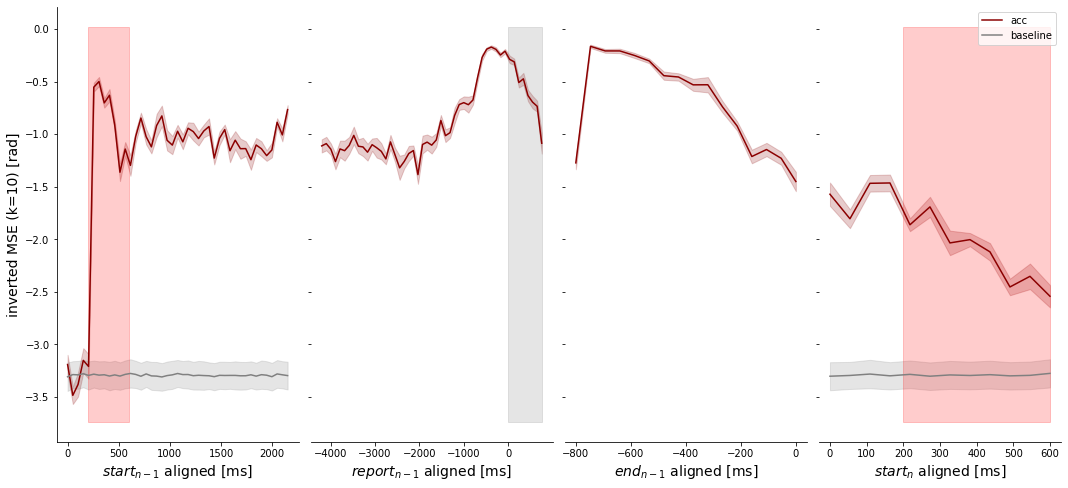

In [65]:
y_targ_prev = df_serial['target_prev'].values-np.pi# target_prev # response_prev

mode = 'MSE'#'r2'#'MSE'#

baseline_file = "../Results/baselineAcc.txt"
baseline = read_baseline(baseline_file, mode)

acc_bias_prev, std_bias_prev, acc_bias_curr, std_bias_curr = decode_continuous_prev_cur(df_serial,y_targ_prev, mode)#MSE
plot_reactivations(acc_bias_prev, std_bias_prev, acc_bias_curr, std_bias_curr, borders, borders_pastdelay, mode, baseline)

# Compare hemispheres

In [17]:
def plot_reactivations_hemispheres(acc_bias_prev_ipsi, std_bias_prev_ipsi, acc_bias_curr_ipsi, std_bias_curr_ipsi,label1,\
                                 acc_bias_prev_contra, std_bias_prev_contra, acc_bias_curr_contra, std_bias_curr_contra,label2,\
                                 borders, borders_pastdelay, mode, baseline):
    # plot only trained/tested in same time bin
    if mode =='MSE':
        acc_bias_prev_ipsi = np.array(acc_bias_prev_ipsi)*-1#100-100/(0.5*np.pi)*np.array(acc_bias_prev_ipsi)
        #std_bias_prev_ipsi = np.array(std_bias_prev_ipsi)*100
        acc_bias_curr_ipsi = np.array(acc_bias_curr_ipsi)*-1#100-100/(0.5*np.pi)*np.array(acc_bias_curr_ipsi)
        #std_bias_curr_ipsi = np.array(std_bias_curr_ipsi)*100
        
        acc_bias_prev_contra = np.array(acc_bias_prev_contra)*-1#100-100/(0.5*np.pi)*np.array(acc_bias_prev_contra)
        #std_bias_prev_contra = np.array(std_bias_prev_contra)*100
        acc_bias_curr_contra = np.array(acc_bias_curr_contra)*-1#100-100/(0.5*np.pi)*np.array(acc_bias_curr_contra)
        #std_bias_curr_contra = np.array(std_bias_curr_contra)*100
        
        baseline['acc_prev'] = np.array(baseline['acc_prev'])*-1
        baseline['acc_curr'] = np.array(baseline['acc_curr'])*-1
    elif mode=='r2':
        acc_bias_prev = acc_bias_prev
    else:
        print('Mode needs to be either:\n'+'r2 for evaluation with r² metric\n'+\
                      'or\nMSE for evaluation with mean-squared error.')
    
    c_base = 'grey'
    
    #x = np.linspace(0,len(acc_bias_prev_ipsi[:borders_full[-2]])*bins, len(acc_bias_prev_ipsi[:borders[-2]]))
    x = np.linspace(0,borders_full[3]*bins, borders_full[3])
    x2 = np.linspace(-(borders_pastdelay[2]-borders[-2])*bins,(borders_pastdelay[3]-borders_pastdelay[2])*bins, len(acc_bias_prev_ipsi[borders[-2]:borders[-1]]))
    #x2 = np.linspace((borders_full[3]-borders_full[4])*bins,(borders_full[7]-borders_full[4])*bins, borders_full[7]-borders_full[3])
    x3 = np.linspace(-(len(acc_bias_prev_ipsi[borders[-1]:]))*bins,0, len(acc_bias_prev_ipsi[borders[-1]:]))
    x4 = np.linspace(0,len(acc_bias_prev_ipsi[:borders[-2]])*bins, len(acc_bias_curr_ipsi[:borders[-2]]))
    labels = np.array(['0', '$S_{n-1}$', '$SE_{n-1}$', '$D_{n-1}$', '$D_{n-1}$','$S_{n-1}$','$R_{n-1}$', '$E_{n-1}$'])
    labels_curr = np.array(['$0_n$', '$S_n$', '$SE_n$'])

    y_low=-1.1
    y_high = 0.8
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,sharey=True, figsize=(18,8))
    plt.subplots_adjust(wspace=0.05)
    ax1.plot(x,acc_bias_prev_ipsi[:borders[-2]], color='darkgreen')
    ax1.plot(x,acc_bias_prev_contra[:borders[-2]], color='darkorange')
    # errorbar
    ax1.fill_between(x, acc_bias_prev_ipsi[:borders[-2]]-0.5*np.array(std_bias_prev_ipsi[:borders[-2]]), acc_bias_prev_ipsi[:borders[-2]]+0.5*np.array(std_bias_prev_ipsi[:borders[-2]]), color='darkgreen', alpha=0.2)
    ax1.fill_between(x, acc_bias_prev_contra[:borders[-2]]-0.5*np.array(std_bias_prev_contra[:borders[-2]]), acc_bias_prev_contra[:borders[-2]]+0.5*np.array(std_bias_prev_contra[:borders[-2]]), color='darkorange', alpha=0.2)
    # plot baseline
    #ax1.axhline(np.mean(baseline['acc_prev']), *ax1.get_xlim(), color='k')
    #ax1.plot(x,baseline['acc_prev'][:borders[-2]], color=c_base)
    #ax1.fill_between(x, baseline['acc_prev'][:borders[-2]]-0.5*np.array(baseline['std_prev'][:borders[-2]]), baseline['acc_prev'][:borders[-2]]+0.5*np.array(baseline['std_prev'][:borders[-2]]), color=c_base, alpha=0.2)

    # mark training time of delay decoder
    #ax1.plot([borders_full[2]*bins,borders_full[3]*bins], [-0.1, -0.1], color='darkgreen', linewidth=6)
    ax1.set_xlabel('$start_{n-1}$ aligned [ms]', fontsize=14)
    if mode =='MSE':
        ax1.set_ylabel('inverted '+str(mode)+' (k=10)', fontsize=14)#avg $r^2$ score
    else:
        ax1.set_ylabel(str(mode)+' (k=10)', fontsize=14)#avg $r^2$ score
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')

    ax2.plot(x2,acc_bias_prev_ipsi[borders[-2]:borders[-1]], color='darkgreen')
    ax2.plot(x2,acc_bias_prev_contra[borders[-2]:borders[-1]], color='darkorange')
    # errorbar
    ax2.fill_between(x2, acc_bias_prev_ipsi[borders[-2]:borders[-1]]-0.5*np.array(std_bias_prev_ipsi[borders[-2]:borders[-1]]), acc_bias_prev_ipsi[borders[-2]:borders[-1]]+0.5*np.array(std_bias_prev_ipsi[borders[-2]:borders[-1]]), color='darkgreen', alpha=0.2)
    ax2.fill_between(x2, acc_bias_prev_contra[borders[-2]:borders[-1]]-0.5*np.array(std_bias_prev_contra[borders[-2]:borders[-1]]), acc_bias_prev_contra[borders[-2]:borders[-1]]+0.5*np.array(std_bias_prev_contra[borders[-2]:borders[-1]]), color='darkorange', alpha=0.2)
    # plot baseline
    #ax2.axhline(np.mean(baseline['acc_prev']), *ax2.get_xlim(), color='k')
    #ax2.plot(x2,baseline['acc_prev'][borders[-2]:borders[-1]], color=c_base)
    #ax2.fill_between(x2, baseline['acc_prev'][borders[-2]:borders[-1]]-0.5*np.array(baseline['std_prev'][borders[-2]:borders[-1]]), baseline['acc_prev'][borders[-2]:borders[-1]]+0.5*np.array(baseline['std_prev'][borders[-2]:borders[-1]]), color=c_base, alpha=0.2)

    # mark training period of response decoder
    #ax2.plot([(borders_full[6]-borders_full[5])*bins,(borders_full[7]-borders_full[5])*bins], [-0.1, -0.1], color='darkorange', linewidth=4)
    ax2.set_xlabel('$report_{n-1}$ aligned [ms]', fontsize=14)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.xaxis.set_ticks_position('bottom')
    
    ax3.plot(x3,acc_bias_prev_ipsi[borders[-1]:], color='darkgreen')
    ax3.plot(x3,acc_bias_prev_contra[borders[-1]:], color='darkorange')
    ax3.fill_between(x3, acc_bias_prev_ipsi[borders[-1]:]-0.5*np.array(std_bias_prev_ipsi[borders[-1]:]), acc_bias_prev_ipsi[borders[-1]:]+0.5*np.array(std_bias_prev_ipsi[borders[-1]:]), color='darkgreen', alpha=0.2)
    ax3.fill_between(x3, acc_bias_prev_contra[borders[-1]:]-0.5*np.array(std_bias_prev_contra[borders[-1]:]), acc_bias_prev_contra[borders[-1]:]+0.5*np.array(std_bias_prev_contra[borders[-1]:]), color='darkorange', alpha=0.2)
    # plot baseline
    #ax3.axhline(np.mean(baseline['acc_prev']), *ax3.get_xlim(), color='k')
    #ax3.plot(x3,baseline['acc_prev'][borders[-1]:], color=c_base)
    #ax3.fill_between(x3, baseline['acc_prev'][borders[-1]:]-0.5*np.array(baseline['std_prev'][borders[-1]:]), baseline['acc_prev'][borders[-1]:]+0.5*np.array(baseline['std_prev'][borders[-1]:]), color=c_base, alpha=0.2)
    #for period in range(len(borders_pastdelay)):
    #    ax2.axvline((borders_pastdelay[period]-borders[-1])*bins, *ax.get_xlim(), color='grey',dashes=[4,2])
    #ax2.set_xticks(bins*np.array(borders_pastdelay-borders[-1]))
    #ax2.set_xticklabels(labels[len(borders):], fontsize=12)
    #ax2.set_yticklabels(fontsize=12)
    ax3.set_xlabel('$end_{n-1}$ aligned [ms]', fontsize=14)
    ax3.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.xaxis.set_ticks_position('bottom')

    ax4.plot(x4,acc_bias_curr_ipsi[:borders[-2]], color='darkgreen', label=label1)
    ax4.plot(x4,acc_bias_curr_contra[:borders[-2]], color='darkorange', label=label2)
    ax4.fill_between(x4, acc_bias_curr_ipsi[:borders[-2]]-0.5*np.array(std_bias_curr_ipsi[:borders[-2]]), acc_bias_curr_ipsi[:borders[-2]]+0.5*np.array(std_bias_curr_ipsi[:borders[-2]]), color='darkgreen', alpha=0.2)
    ax4.fill_between(x4, acc_bias_curr_contra[:borders[-2]]-0.5*np.array(std_bias_curr_contra[:borders[-2]]), acc_bias_curr_contra[:borders[-2]]+0.5*np.array(std_bias_curr_contra[:borders[-2]]), color='darkorange', alpha=0.2)
    # plot baseline
    #ax4.axhline(np.mean(baseline['acc_prev']), *ax4.get_xlim(), color='k')
    #ax4.plot(x4,baseline['acc_curr'][:borders[-3]], color=c_base, label='baseline')
    #ax4.fill_between(x4, baseline['acc_curr'][:borders[-3]]-0.5*np.array(baseline['std_curr'][:borders[-3]]), baseline['acc_curr'][:borders[-3]]+0.5*np.array(baseline['std_curr'][:borders[-3]]), color=c_base, alpha=0.2)
    #for period in range(len(borders[:3])):
    #    ax3.axvline(borders[period]*bins, *ax.get_ylim(), color='grey',dashes=[4,2])
    #ax3.set_xticks(bins*np.array(borders[:3]))
    #ax3.set_xticklabels(labels_curr, fontsize=12)
    ax4.set_xlabel('$start_n$ aligned [ms]', fontsize=14)
    ax4.spines['right'].set_visible(False)
    ax4.spines['left'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.xaxis.set_ticks_position('bottom')

    y0=ax2.get_ylim()[0]
    y1=ax2.get_ylim()[1]
    ax1.fill_between([borders_full[1]*bins, borders_full[2]*bins], y0, y1, color='red', alpha=0.2)
    ax2.fill_between([0, (borders_full[5]-borders_full[6])*bins], y0,y1, color='grey', alpha=0.2)
    ax4.fill_between([borders_full[1]*bins, borders_full[2]*bins], y0,y1, color='red', alpha=0.2)

    plt.legend(fontsize=16)
    #plt.savefig('../Figures/Neural/SerialBias/DelayResponseDecoder/DelayResponseDecoder_reward_sincos_MSE_Sa2.png', dpi=100)

    plt.show()
    
    if mode =='MSE':
        baseline['acc_prev'] = np.array(baseline['acc_prev'])*-1
        baseline['acc_curr'] = np.array(baseline['acc_curr'])*-1
    return

In [18]:
# idx neurons each hemispheres
left = np.where(left_idx['Sa'][2]==1)[1]#
right = np.where(right_idx['Sa'][2]==1)[1]

# target position left/right
targ_left = np.where((df_serial['target_prev']>np.pi/2) & (df_serial['target_prev']<np.pi+np.pi/2))[0]
targ_right = np.where((df_serial['target_prev']<np.pi/2) | (df_serial['target_prev']>np.pi+np.pi/2))[0]

In [19]:
# create dataframe with only left neurons
df_serial_left = df_serial.copy()# ['bin_sp_prev'][0][0][left]
df_serial_left.drop(['bin_sp_prev'], axis=1)
df_serial_left['bin_sp_prev'] = [[df_serial['bin_sp_prev'][n][t][left] for t in range(len(df_serial['bin_sp_prev'][n]))] for n in range(len(df_serial['bin_sp_prev']))]

# only right neurons
df_serial_right = df_serial.copy()# ['bin_sp_prev'][0][0][left]
df_serial_right.drop(['bin_sp_prev'], axis=1)
df_serial_right['bin_sp_prev'] = [[df_serial['bin_sp_prev'][n][t][right] for t in range(len(df_serial['bin_sp_prev'][n]))] for n in range(len(df_serial['bin_sp_prev']))]


## decode only left neurons (ipsilateral, contralateral)

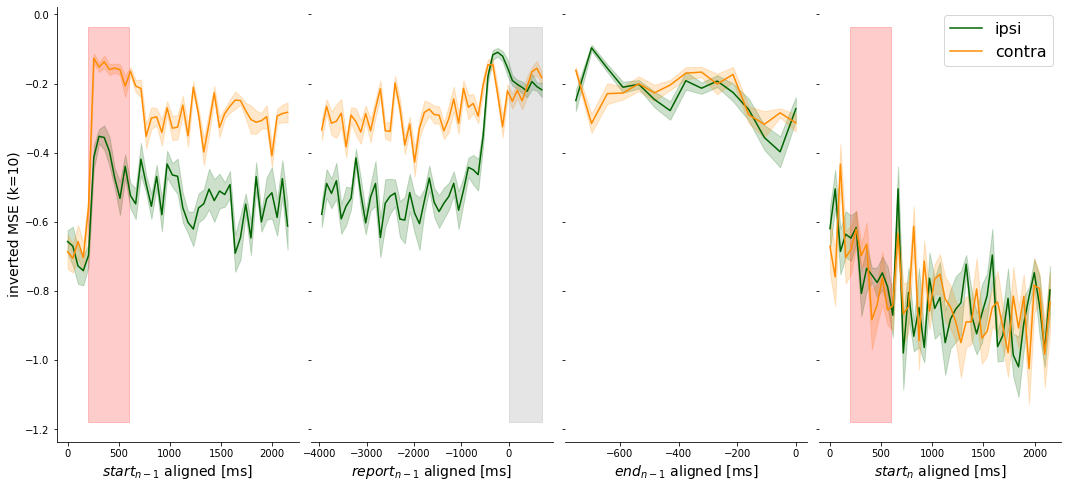

In [94]:
y_targ_prev_left = df_serial_left.loc[targ_left]['target_prev'].values-np.pi# make to -180-180° 
y_targ_prev_right = df_serial_right.loc[targ_right]['target_prev'].values-np.pi# target_prev # response_prev
mode='MSE'

#ipsilateral:
acc_bias_prev_left_ipsi, std_bias_prev_left_ipsi, acc_bias_curr_left_ipsi, std_bias_curr_left_ipsi = decode_continuous_prev_cur(df_serial_left.loc[targ_left], y_targ_prev_left, mode)
label_ipsi = 'ipsi'
#contralateral:
acc_bias_prev_left_contra, std_bias_prev_left_contra, acc_bias_curr_left_contra, std_bias_curr_left_contra = decode_continuous_prev_cur(df_serial_left.loc[targ_right], y_targ_prev_right, mode)
label_contra='contra'

plot_reactivations_hemispheres(acc_bias_prev_left_ipsi, std_bias_prev_left_ipsi, acc_bias_curr_left_ipsi, std_bias_curr_left_ipsi,label_ipsi,\
                                 acc_bias_prev_left_contra, std_bias_prev_left_contra, acc_bias_curr_left_contra, std_bias_curr_left_contra,label_contra,\
                                 borders, borders_pastdelay, mode, baseline)

## decode only right neurons (ipsilateral trials, contralateral trials)

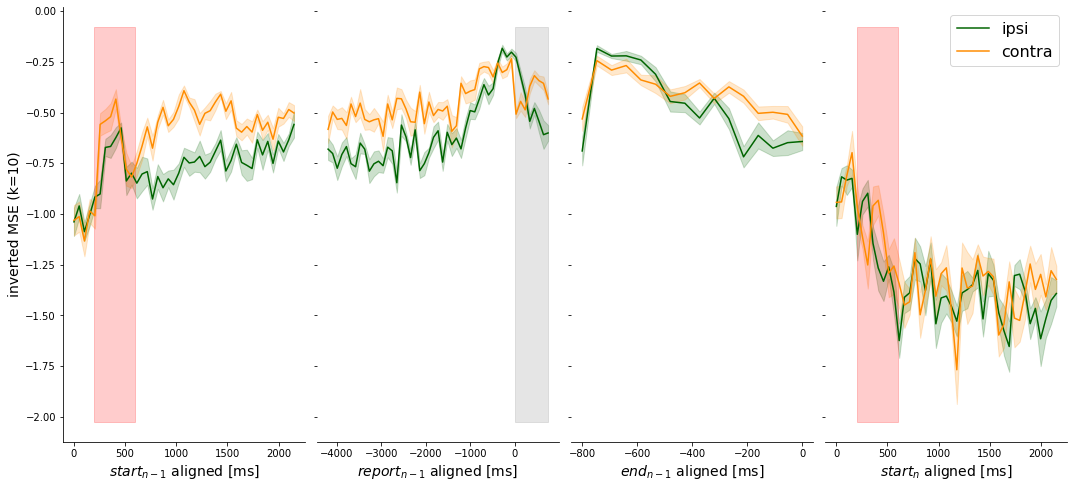

In [35]:
#acc_bias_prev_right, std_bias_prev_right, acc_bias_curr_right, std_bias_curr_right = decode_continuous_prev_cur(df_serial_right.loc[targ_right])
#plot_reactivations(acc_bias_prev_right, std_bias_prev_right, acc_bias_curr_right, std_bias_curr_right, borders, borders_pastdelay)

#ipsilateral:
acc_bias_prev_right_ipsi, std_bias_prev_right_ipsi, acc_bias_curr_right_ipsi, std_bias_curr_right_ipsi = decode_continuous_prev_cur(df_serial_right.loc[targ_right], y_targ_prev_right, mode)
#contralateral:
acc_bias_prev_right_contra, std_bias_prev_right_contra, acc_bias_curr_right_contra, std_bias_curr_right_contra = decode_continuous_prev_cur(df_serial_right.loc[targ_left], y_targ_prev_left, mode)

plot_reactivations_hemispheres(acc_bias_prev_right_ipsi, std_bias_prev_right_ipsi, acc_bias_curr_right_ipsi, std_bias_curr_right_ipsi,label_ipsi,\
                                 acc_bias_prev_right_contra, std_bias_prev_right_contra, acc_bias_curr_right_contra, std_bias_curr_right_contra,label_contra,\
                                 borders, borders_pastdelay, mode, baseline)


# Use delay vs response decoder

In [143]:
# y is fixed only X changes based on time in trial
mode='MSE'

y = df_serial['target_prev']-np.pi# target_prev # response_prev

# train in previous trial delay (mean over individual delay length )
X_delay = pd.DataFrame([np.mean(df_serial['bin_sp_prev'][n][borders_full[2]:borders_full[3]], axis=0) for n in range(len(df_serial['bin_sp_prev']))])
# train in previous trial response (ITI=borders[6:7], reward= borders[5:6])
X_response = pd.DataFrame([np.mean(df_serial['bin_sp_prev'][n][borders_full[6]+10:borders_full[7]],axis=0) for n in range(len(df_serial['bin_sp_prev']))])

acc_bias_prev_delay = []
std_bias_prev_delay = []
acc_bias_curr_delay = []
std_bias_curr_delay = []
acc_bias_prev_response=[]
std_bias_prev_response=[]
acc_bias_curr_response=[]
std_bias_curr_response=[]
for delta_t_train in range(len(df_serial['bin_sp_prev'][df_serial['bin_sp_prev'].index[0]])):# for each period ['targ_on', 'targ_off', 'go_cue', 'saccade', 'reward']
    # create training dataset: columns=neurons, rows=trials within specified time bin(in period)
    X_prev = pd.DataFrame([df_serial['bin_sp_prev'][n][delta_t_train] for n in range(len(df_serial['bin_sp_prev']))])
    X_curr = pd.DataFrame([df_serial['bin_sp_curr'][n][delta_t_train] for n in range(len(df_serial['bin_sp_curr']))])

    # Crossvalidation
    acc_crosscorr_prev_delay=[]
    acc_crosscorr_curr_delay=[]
    acc_crosscorr_prev_response=[]
    acc_crosscorr_curr_response=[] 
    for k in range(0,10):# k=10 as in Barbosa2020
        #train test split
        rand_state = randint(0,10000)# to get the same split for previous, current
        X_train_delay, X_i, y_train, y_i = train_test_split(X_delay, y, test_size = 0.20, random_state=rand_state)# train in slow loop
        X_train_response, X_i, y_train, y_i = train_test_split(X_response, y, test_size = 0.20, random_state=rand_state)# train in slow loop
        X_i, X_test_prev, y_i, y_test = train_test_split(X_prev, y, test_size = 0.20, random_state=rand_state)# test in fast loop
        X_i, X_test_curr, y_i, y_test = train_test_split(X_curr, y, test_size = 0.20, random_state=rand_state)# test in fast loop

        # determine labels (sine, cosine)
        #assert (y_train_delay == y_train_response).all()
        y_train_cos = np.cos(y_train)
        y_train_sin = np.sin(y_train)
        #y_test_cos = np.cos(y_test)

        # make linear regression fit for sine/cosine for prev/current trial
        model_d_cos = LinearRegression().fit(X_train_delay, y_train_cos)
        model_d_sin = LinearRegression().fit(X_train_delay, y_train_sin)
        model_r_cos = LinearRegression().fit(X_train_response, y_train_cos)
        model_r_sin = LinearRegression().fit(X_train_response, y_train_sin)

        # make predictions of models
        preds_prev_d_cos = model_d_cos.predict(X_test_prev)
        preds_prev_d_sin = model_d_sin.predict(X_test_prev)
        preds_curr_d_cos = model_d_cos.predict(X_test_curr)
        preds_curr_d_sin = model_d_sin.predict(X_test_curr)
        preds_prev_r_cos = model_r_cos.predict(X_test_prev)
        preds_prev_r_sin = model_r_sin.predict(X_test_prev)
        preds_curr_r_cos = model_r_cos.predict(X_test_curr)
        preds_curr_r_sin = model_r_sin.predict(X_test_curr)

        preds_d_prev = [math.atan2(preds_prev_d_sin[n],preds_prev_d_cos[n]) for n in range(len(preds_prev_d_sin))]
        preds_d_curr = [math.atan2(preds_curr_d_sin[n],preds_curr_d_cos[n]) for n in range(len(preds_curr_d_sin))]
        preds_r_prev = [math.atan2(preds_prev_r_sin[n],preds_prev_r_cos[n]) for n in range(len(preds_prev_r_sin))]
        preds_r_curr = [math.atan2(preds_curr_r_sin[n],preds_curr_r_cos[n]) for n in range(len(preds_curr_r_sin))]
    
        # R squared value
        if mode == 'r2':
            acc_crosscorr_prev_delay.append(metrics.r2_score(preds_d_prev, y_test.values))
            acc_crosscorr_curr_delay.append(metrics.r2_score(preds_d_curr, y_test.values))
            acc_crosscorr_prev_response.append(metrics.r2_score(preds_r_prev, y_test.values))
            acc_crosscorr_curr_response.append(metrics.r2_score(preds_r_curr, y_test.values))
        elif mode == 'MSE':
            acc_crosscorr_prev_delay.append(np.mean((circdist(preds_d_prev, y_test.values)**2)))
            acc_crosscorr_curr_delay.append(np.mean((circdist(preds_d_curr, y_test.values)**2)))
            acc_crosscorr_prev_response.append(np.mean((circdist(preds_r_prev, y_test.values)**2)))
            acc_crosscorr_curr_response.append(np.mean((circdist(preds_r_curr, y_test.values)**2)))
        else:
            print('Mode needs to be either:\n'+'r2 for evaluation with R² metric \n'+\
                      'or\nMSE for evaluation with mean-squared error.')
    acc_bias_prev_delay.append(np.mean(acc_crosscorr_prev_delay))
    std_bias_prev_delay.append(np.std(acc_crosscorr_prev_delay))
    acc_bias_curr_delay.append(np.mean(acc_crosscorr_curr_delay))
    std_bias_curr_delay.append(np.std(acc_crosscorr_curr_delay))
    
    acc_bias_prev_response.append(np.mean(acc_crosscorr_prev_response))
    std_bias_prev_response.append(np.std(acc_crosscorr_prev_response))
    acc_bias_curr_response.append(np.mean(acc_crosscorr_curr_response))
    std_bias_curr_response.append(np.std(acc_crosscorr_curr_response))


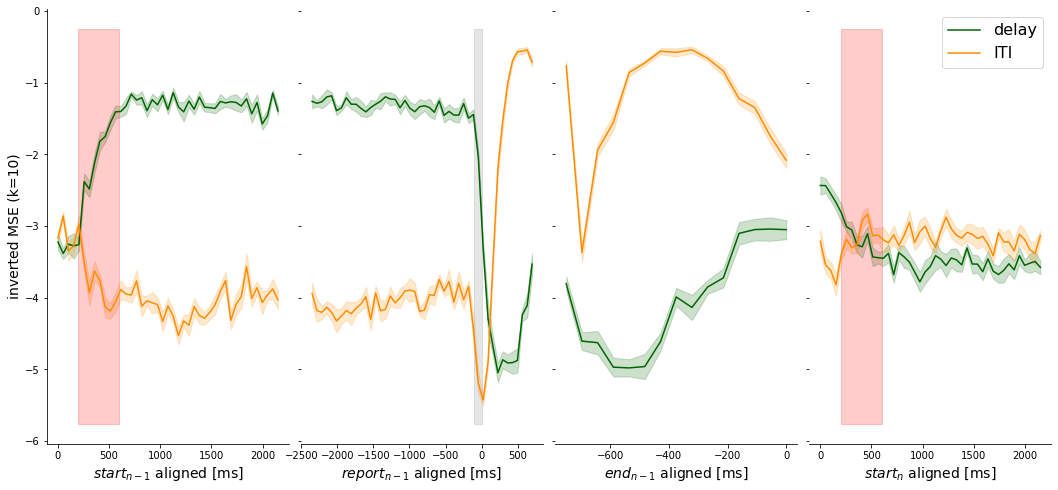

In [144]:
label_delay = 'delay'
label_response = 'ITI'

mode = 'MSE'#'r2'#'MSE'#
baseline_file = "../Results/baselineAcc.txt"
baseline = read_baseline(baseline_file, mode)
plot_reactivations_hemispheres(acc_bias_prev_delay, std_bias_prev_delay, acc_bias_curr_delay, std_bias_curr_delay, label_delay,\
                                 acc_bias_prev_response, std_bias_prev_response, acc_bias_curr_response, std_bias_curr_response,label_response,\
                                 borders, borders_pastdelay, mode, baseline)

# CW, CCW analysis

## Leave-1 out crossvalidation

In [21]:
def decode_continuous_leave1out(dataframe,y, mode):
    # y is fixed only X changes based on time in trial

    acc_prev = []
    std_prev = []
    acc_curr = []
    std_curr = []
    for delta_t_train in range(len(df_serial['bin_sp_prev'][df_serial['bin_sp_prev'].index[0]])):# for each period ['targ_on', 'targ_off', 'go_cue', 'saccade', 'reward']
        # create training dataset: columns=neurons, rows=trials for previous/current trials
        X_prev = pd.DataFrame([dataframe['bin_sp_prev'][n][delta_t_train] for n in dataframe['bin_sp_prev'].index])
        X_curr = pd.DataFrame([dataframe['bin_sp_curr'][n][delta_t_train] for n in dataframe['bin_sp_curr'].index])
        
        # Crossvalidation
        acc_crosscorr_prev=[]
        acc_crosscorr_curr=[]
        
        loo = LeaveOneOut()
        for train_idx, test_idx in loo.split(X_prev):
            X_train_prev, X_test_prev = X_prev.loc[train_idx], X_prev.loc[test_idx]
            X_train_curr, X_test_curr = X_curr.loc[train_idx], X_curr.loc[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # determine labels (sine, cosine)
            y_train_cos = np.cos(y_train)
            y_train_sin = np.sin(y_train)
            #y_test_cos = np.cos(y_test)

            # make linear regression fit for sine/cosine for prev/current trial
            model_prev_cos = LinearRegression().fit(X_train_prev, y_train_cos)
            model_prev_sin = LinearRegression().fit(X_train_prev, y_train_sin)
            model_curr_cos = LinearRegression().fit(X_train_curr, y_train_cos)
            model_curr_sin = LinearRegression().fit(X_train_curr, y_train_sin)

            # make predictions of models
            preds_prev_cos = model_prev_cos.predict(X_test_prev)
            preds_prev_sin = model_prev_sin.predict(X_test_prev)
            preds_curr_cos = model_curr_cos.predict(X_test_curr)
            preds_curr_sin = model_curr_sin.predict(X_test_curr)

            preds_prev = [math.atan2(preds_prev_sin[n],preds_prev_cos[n]) for n in range(len(preds_prev_sin))]
            preds_curr = [math.atan2(preds_curr_sin[n],preds_curr_cos[n]) for n in range(len(preds_prev_sin))]

            # R squared value
            if mode == 'r2':
                acc_crosscorr_prev.append(metrics.r2_score(preds_prev, y_test))
                acc_crosscorr_curr.append(metrics.r2_score(preds_curr, y_test))
            elif mode == 'MSE':
                #acc_crosscorr_prev.append(np.mean(abs(circdist(preds_prev, y_test))))
                #acc_crosscorr_curr.append(np.mean(abs(circdist(preds_curr, y_test))))
                acc_crosscorr_prev.append(np.mean(circdist(preds_prev, y_test.values)**2))
                acc_crosscorr_curr.append(np.mean(circdist(preds_curr, y_test.values)**2))
            else:
                print('Mode needs to be either:\n'+'r2 for evaluation with R² metric \n'+\
                          'or\nMSE for evaluation with mean-squared error.')
                return
            

        acc_prev.append(acc_crosscorr_prev)
        #std_prev.append(np.std(acc_crosscorr_prev))
        acc_curr.append(acc_crosscorr_curr)
        #std_curr.append(np.std(acc_crosscorr_curr))
    return acc_prev, acc_curr


In [22]:
def plot_singleTrial(acc_bias_prev,acc_bias_curr,mode):
    # plot only trained/tested in same time bin
    if mode =='MSE':
        acc_bias_prev = np.array(acc_bias_prev)*-1#100-100/(0.5*np.pi)*np.array(acc_bias_prev_ipsi)
        acc_bias_curr = np.array(acc_bias_curr)*-1#100-100/(0.5*np.pi)*np.array(acc_bias_curr_ipsi)
        
        #baseline['acc_prev'] = np.array(baseline['acc_prev'])*-1
        #baseline['acc_curr'] = np.array(baseline['acc_curr'])*-1
    elif mode=='r2':
        acc_bias_prev = acc_bias_prev
    else:
        print('Mode needs to be either:\n'+'r2 for evaluation with r² metric\n'+\
                      'or\nMSE for evaluation with mean-squared error.')
    
    c_base = 'grey'
    
    x = np.linspace(0,len(acc_bias_prev[:borders[-2]])*bins, len(acc_bias_prev[:borders[-2]]))
    x2 = np.linspace(-(borders_pastdelay[2]-borders[-2])*bins,(borders_pastdelay[3]-borders_pastdelay[2])*bins, len(acc_bias_prev_ipsi[borders[-2]:borders[-1]]))
    x3 = np.linspace(-(len(acc_bias_prev_ipsi[borders[-1]:]))*bins,0, len(acc_bias_prev_ipsi[borders[-1]:]))
    x4 = np.linspace(0,len(acc_bias_prev_ipsi[:borders[-2]])*bins, len(acc_bias_curr_ipsi[:borders[-2]]))
    labels = np.array(['0', '$S_{n-1}$', '$SE_{n-1}$', '$D_{n-1}$', '$D_{n-1}$','$S_{n-1}$','$R_{n-1}$', '$E_{n-1}$'])
    labels_curr = np.array(['$0_n$', '$S_n$', '$SE_n$'])

    y_low=-1.1
    y_high = 0.8
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,sharey=True, figsize=(18,8))
    plt.subplots_adjust(wspace=0.05)
    ax1.plot(x,acc_bias_prev_ipsi[:borders[-2]], color='darkgreen')
    ax1.plot(x,acc_bias_prev_contra[:borders[-2]], color='darkorange')
    # errorbar
    ax1.fill_between(x, acc_bias_prev_ipsi[:borders[-2]]-0.5*np.array(std_bias_prev_ipsi[:borders[-2]]), acc_bias_prev_ipsi[:borders[-2]]+0.5*np.array(std_bias_prev_ipsi[:borders[-2]]), color='darkgreen', alpha=0.2)
    ax1.fill_between(x, acc_bias_prev_contra[:borders[-2]]-0.5*np.array(std_bias_prev_contra[:borders[-2]]), acc_bias_prev_contra[:borders[-2]]+0.5*np.array(std_bias_prev_contra[:borders[-2]]), color='darkorange', alpha=0.2)
    # plot baseline
    #ax1.plot(x,baseline['acc_prev'][:borders[-2]], color=c_base)
    #ax1.fill_between(x, baseline['acc_prev'][:borders[-2]]-0.5*np.array(baseline['std_prev'][:borders[-2]]), baseline['acc_prev'][:borders[-2]]+0.5*np.array(baseline['std_prev'][:borders[-2]]), color=c_base, alpha=0.2)
    #for period in range(len(borders)):
    #    ax1.axvline(borders[period]*bins, *ax.get_xlim(), color='grey',dashes=[4,2])
    #ax1.set_xticks(bins*np.array(borders))
    #ax1.set_xticklabels(labels[:len(borders)], fontsize=12)
    #ax1.set_yticklabels(fontsize=12)
    ax1.set_xlabel('$start_{n-1}$ aligned [ms]', fontsize=14)
    if mode =='MSE':
        ax1.set_ylabel('inverted '+str(mode)+' (k=10)', fontsize=14)#avg $r^2$ score
    else:
        ax1.set_ylabel(str(mode)+' (k=10)', fontsize=14)#avg $r^2$ score
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')

    ax2.plot(x2,acc_bias_prev_ipsi[borders[-2]:borders[-1]], color='darkgreen')
    ax2.plot(x2,acc_bias_prev_contra[borders[-2]:borders[-1]], color='darkorange')
    # errorbar
    ax2.fill_between(x2, acc_bias_prev_ipsi[borders[-2]:borders[-1]]-0.5*np.array(std_bias_prev_ipsi[borders[-2]:borders[-1]]), acc_bias_prev_ipsi[borders[-2]:borders[-1]]+0.5*np.array(std_bias_prev_ipsi[borders[-2]:borders[-1]]), color='darkgreen', alpha=0.2)
    ax2.fill_between(x2, acc_bias_prev_contra[borders[-2]:borders[-1]]-0.5*np.array(std_bias_prev_contra[borders[-2]:borders[-1]]), acc_bias_prev_contra[borders[-2]:borders[-1]]+0.5*np.array(std_bias_prev_contra[borders[-2]:borders[-1]]), color='darkorange', alpha=0.2)
    # plot baseline
    #ax2.plot(x2,baseline['acc_prev'][borders[-2]:borders[-1]], color=c_base)
    #ax2.fill_between(x2, baseline['acc_prev'][borders[-2]:borders[-1]]-0.5*np.array(baseline['std_prev'][borders[-2]:borders[-1]]), baseline['acc_prev'][borders[-2]:borders[-1]]+0.5*np.array(baseline['std_prev'][borders[-2]:borders[-1]]), color=c_base, alpha=0.2)
    #for period in range(len(borders_pastdelay)):
    #    ax2.axvline((borders_pastdelay[period]-borders[-1])*bins, *ax.get_xlim(), color='grey',dashes=[4,2])
    #ax2.set_xticks(bins*np.array(borders_pastdelay-borders[-1]))
    #ax2.set_xticklabels(labels[len(borders):], fontsize=12)
    #ax2.set_yticklabels(fontsize=12)
    ax2.set_xlabel('$report_{n-1}$ aligned [ms]', fontsize=14)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.xaxis.set_ticks_position('bottom')
    
    ax3.plot(x3,acc_bias_prev_ipsi[borders[-1]:], color='darkgreen')
    ax3.plot(x3,acc_bias_prev_contra[borders[-1]:], color='darkorange')
    ax3.fill_between(x3, acc_bias_prev_ipsi[borders[-1]:]-0.5*np.array(std_bias_prev_ipsi[borders[-1]:]), acc_bias_prev_ipsi[borders[-1]:]+0.5*np.array(std_bias_prev_ipsi[borders[-1]:]), color='darkgreen', alpha=0.2)
    ax3.fill_between(x3, acc_bias_prev_contra[borders[-1]:]-0.5*np.array(std_bias_prev_contra[borders[-1]:]), acc_bias_prev_contra[borders[-1]:]+0.5*np.array(std_bias_prev_contra[borders[-1]:]), color='darkorange', alpha=0.2)
    # plot baseline
    #ax3.plot(x3,baseline['acc_prev'][borders[-1]:], color=c_base)
    #ax3.fill_between(x3, baseline['acc_prev'][borders[-1]:]-0.5*np.array(baseline['std_prev'][borders[-1]:]), baseline['acc_prev'][borders[-1]:]+0.5*np.array(baseline['std_prev'][borders[-1]:]), color=c_base, alpha=0.2)
    #for period in range(len(borders_pastdelay)):
    #    ax2.axvline((borders_pastdelay[period]-borders[-1])*bins, *ax.get_xlim(), color='grey',dashes=[4,2])
    #ax2.set_xticks(bins*np.array(borders_pastdelay-borders[-1]))
    #ax2.set_xticklabels(labels[len(borders):], fontsize=12)
    #ax2.set_yticklabels(fontsize=12)
    ax3.set_xlabel('$end_{n-1}$ aligned [ms]', fontsize=14)
    ax3.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.xaxis.set_ticks_position('bottom')

    ax4.plot(x4,acc_bias_curr_ipsi[:borders[-2]], color='darkgreen', label=label1)
    ax4.plot(x4,acc_bias_curr_contra[:borders[-2]], color='darkorange', label=label2)
    ax4.fill_between(x4, acc_bias_curr_ipsi[:borders[-2]]-0.5*np.array(std_bias_curr_ipsi[:borders[-2]]), acc_bias_curr_ipsi[:borders[-2]]+0.5*np.array(std_bias_curr_ipsi[:borders[-2]]), color='darkgreen', alpha=0.2)
    ax4.fill_between(x4, acc_bias_curr_contra[:borders[-2]]-0.5*np.array(std_bias_curr_contra[:borders[-2]]), acc_bias_curr_contra[:borders[-2]]+0.5*np.array(std_bias_curr_contra[:borders[-2]]), color='darkorange', alpha=0.2)
    # plot baseline
    #ax4.plot(x4,baseline['acc_curr'][:borders[-3]], color=c_base, label='baseline')
    #ax4.fill_between(x4, baseline['acc_curr'][:borders[-3]]-0.5*np.array(baseline['std_curr'][:borders[-3]]), baseline['acc_curr'][:borders[-3]]+0.5*np.array(baseline['std_curr'][:borders[-3]]), color=c_base, alpha=0.2)
    #for period in range(len(borders[:3])):
    #    ax3.axvline(borders[period]*bins, *ax.get_ylim(), color='grey',dashes=[4,2])
    #ax3.set_xticks(bins*np.array(borders[:3]))
    #ax3.set_xticklabels(labels_curr, fontsize=12)
    ax4.set_xlabel('$start_n$ aligned [ms]', fontsize=14)
    ax4.spines['right'].set_visible(False)
    ax4.spines['left'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.xaxis.set_ticks_position('bottom')

    y0=ax2.get_ylim()[0]
    y1=ax2.get_ylim()[1]
    ax1.fill_between([borders[1]*bins, borders[2]*bins], y0, y1, color='red', alpha=0.2)
    ax2.fill_between([0, (borders_pastdelay[3]-borders_pastdelay[2])*bins], y0,y1, color='grey', alpha=0.2)
    ax4.fill_between([borders[1]*bins, borders[2]*bins], y0,y1, color='red', alpha=0.2)

    plt.legend(fontsize=16)
    #plt.savefig('../Figures/Neural/SerialBias/hemispheres/right/TargetDecoding_right_sincos_MSE_Sa0.png', dpi=100)

    plt.show()
    
    if mode =='MSE':
        baseline['acc_prev'] = np.array(baseline['acc_prev'])*-1
        baseline['acc_curr'] = np.array(baseline['acc_curr'])*-1
    return

In [ ]:
df_cw = df_serial.loc[df_serial['cw']==True].reset_index()
df_ccw = df_serial.loc[df_serial['cw']==False].reset_index()
y_cw = df_cw['target_prev']-np.pi
y_ccw = df_ccw['target_prev']-np.pi

acc_prev_cw, acc_curr_cw = decode_continuous_leave1out(df_cw, y_cw, mode)

In [ ]:
plot_singleTrial(acc_prev_cw[0], acc_curr_cw[0])

In [82]:
acc_bias_prev_ccw, std_bias_prev_ccw,\
acc_bias_curr_ccw, std_bias_curr_ccw = decode_continuous_leave1out(df_ccw,y_ccw, mode)

## CW vs CCW decoding  at delay end

In [20]:
def decode_response_leave1out(dataframe,y):
    """Leave-1-out crossvalidation on neural data. Response decoding during end of delay period
    
    INPUT:      dataframe = pd Dataframe of a single session, all trials
                y         = targets for each trial
                
    OUTPUT:     pred_error = circular distance of predicted response with response for each trial
                pred_sign  = sign of prediction error
    
    """
    pred_error=[]
    pred_clockw=[]
    
    # Leave one out crossvalidation
    loo = LeaveOneOut()
    for train_idx, test_idx in loo.split(dataframe):
        # only train on the time of the end of the delay (backwards aligned delay 2nd half of delay)
        #delta_t_train = borders_full[3:5]# 
        # create training dataset: columns=neurons, rows=trials for previous/current trials
        X = pd.DataFrame([np.mean(dataframe['bin_sp'][n][borders_full[3]:borders_full[4]], axis=0) for n in dataframe.index])

        #X = pd.DataFrame([dataframe['bin_sp'][n][delta_t_train[n-min(dataframe.index)]] for n in dataframe.index])
      
        X_train, X_test = X.loc[train_idx], X.loc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # determine labels (sine, cosine)
        y_train_cos = np.cos(y_train)
        y_train_sin = np.sin(y_train)

        # make linear regression fit for sin/cosine for prev/current trial
        model_cos = LinearRegression().fit(X_train, y_train_cos)
        model_sin = LinearRegression().fit(X_train, y_train_sin)

        # make predictions of models
        preds_cos = model_cos.predict(X_test)
        preds_sin = model_sin.predict(X_test)

        preds = [math.atan2(preds_sin[n],preds_cos[n]) for n in range(len(preds_sin))]

        # distance between prediction, result
        pred_error.append(circdist(preds, y_test))
        pred_clockw.append(['CW' if np.sign(circdist(preds, y_test))[n]>0 else 'CCW' for n in range(len(np.sign(circdist(preds, y_test))))])

    return pred_error, pred_clockw


In [256]:
y = df_Sa0['targ_angle'].values*np.pi/180-np.pi # convert to radians in [-np.pi, np.pi]
df_onetrial = df_Sa0

In [257]:
y = df_Sa0['targ_angle'].values*np.pi/180-np.pi # convert to radians in [-np.pi, np.pi]
df_onetrial = df_Sa0.reset_index()
pred_error, pred_clockw = decode_response_leave1out(df_onetrial,y)

In [258]:
acc_large=[]
for cut in range(50):# for each degree until maximum degree
    acc_large.append(accuracy_score(df_Sa0.loc[abs(np.array(pred_error)*180/np.pi)>cut,'clockw'].values=='CW',\
                                    np.array(pred_error)[abs(np.array(pred_error)*180/np.pi)>cut]>0))
    

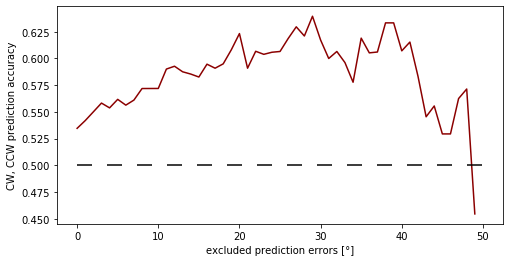

In [170]:
plt.figure(figsize=(8,4))
plt.plot(acc_large, color='darkred')
plt.plot([0,50],[0.5,0.5], dashes=[10,10], color='k')
plt.xlabel('excluded prediction errors [°]')
plt.ylabel('CW, CCW prediction accuracy')
#plt.savefig('../Figures/Neural/CWvsCCW/CWvsCCWpredictionAcc.png', dpi=100)
plt.show()

## CW/CCW over time

In [21]:
def decode_response_leave1out_timeTrain(dataframe,y):
    """Leave-1-out crossvalidation on neural data. Response decoding during end of delay period
    
    INPUT:      dataframe = pd Dataframe of a single session, all trials
                y         = targets for each trial
                
    OUTPUT:     pred_error = circular distance of predicted response with response for each trial
                pred_sign  = sign of prediction error
    
    """
    pred_error=[]
    pred_clockw=[]
    pred_angle=[]
    
    # Leave one out crossvalidation
    loo = LeaveOneOut()
    for train_idx, test_idx in loo.split(dataframe): 
        # create training dataset: columns=neurons, rows=trials for previous/current trials, train during end of delay
        X = pd.DataFrame([np.mean(dataframe['bin_sp'][n][borders_full[3]:borders_full[4]], axis=0) for n in dataframe.index])
        
        X_train = X.loc[train_idx] # training stays constant 
        y_train, y_test = y[train_idx], y[test_idx]
        
        # determine labels (sine, cosine)
        y_train_cos = np.cos(y_train)
        y_train_sin = np.sin(y_train)
        
        # make linear regression fit for sin/cosine for prev/current trial
        model_cos = LinearRegression().fit(X_train, y_train_cos)
        model_sin = LinearRegression().fit(X_train, y_train_sin)
        
        pred_error_bin=[]
        pred_clockw_bin=[]
        pred_angle_bin=[]
        # predict during entire delay, varying bins
        for delta_t_train in range(borders_full[3], borders_full[4]):# test during entire delay 
            X_test = pd.DataFrame(dataframe['bin_sp'][test_idx[0]][delta_t_train])  # only change testing data in time  
            X_test = X_test.transpose()

            # make predictions of models
            preds_cos = model_cos.predict(X_test)
            preds_sin = model_sin.predict(X_test)

            preds = [math.atan2(preds_sin[n],preds_cos[n]) for n in range(len(preds_sin))]

            # distance between prediction, result
            pred_error_bin.append(circdist(preds, y_test))
            pred_clockw_bin.append(['CW' if np.sign(circdist(preds, y_test))[n]>0 else 'CCW' for n in range(len(np.sign(circdist(preds, y_test))))])
            pred_angle_bin.append(preds)
        pred_error.append(pred_error_bin)
        pred_clockw.append(pred_clockw_bin)
        pred_angle.append(pred_angle_bin)
    return pred_error, pred_clockw, pred_angle


In [22]:
y = df_Sa0['targ_angle'].values*np.pi/180-np.pi # convert to radians in [-np.pi, np.pi]
df_onetrial = df_Sa0.reset_index()
pred_error, pred_clockw, pred_angle = decode_response_leave1out_timeTrain(df_onetrial,y)


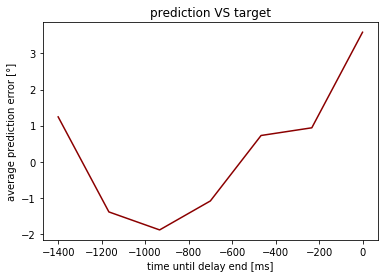

In [23]:
x_acc = np.linspace((borders_full[3]-borders_full[4])*bins,0,borders_full[4]-borders_full[3])
plt.figure()
plt.plot(x_acc,np.mean(np.array(pred_error)*180/np.pi,axis=0), color='darkred')
plt.xlabel('time until delay end [ms]')
plt.ylabel('average prediction error [°]')
plt.title('prediction VS target')
plt.show()

-> this increases because over longer delays, response acc decreases

In [24]:
cut_off = 5 # trials with error<cut_off are excluded from analysis

binaryAcc_time=[]
contAcc_time=[]
contAcc_time_p=[]
for t in range(len(pred_clockw[0])):
    pred_cw = np.concatenate([pred_clockw[n][t] for n in range(len(pred_clockw))]) # for one time point, each trial determine predictions
    pred_cont = np.concatenate([pred_angle[n][t] for n in range(len(pred_angle))]) # for one time point, each trial determine predictions

    # only evaluate where prediction error is larger cut_off value (safer predictions)
    err_idx = np.where(np.array(np.concatenate([pred_error[n][t] for n in df_onetrial.index]))*180/np.pi>cut_off)[0]
    binaryAcc_time.append(accuracy_score(df_onetrial['clockw'].values[err_idx], pred_cw[err_idx]))
    contAcc_time.append(np.mean((circdist(df_onetrial['saccade_angle'].values[err_idx]*np.pi/180, pred_cont[err_idx])**2)))
    #df_Sa0['saccade_angle'].values
    

### WHY IS CONTINUOUS DECODING NOT DECREASING THE ERROR?

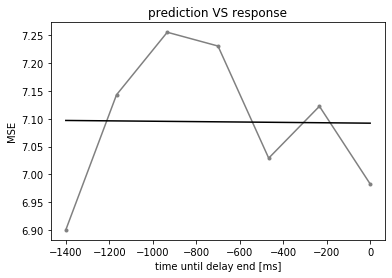

In [175]:
X = (np.arange(-len(binaryAcc_time),0)*bins)
params = LinearRegression().fit(X.reshape(-1,1), np.array(contAcc_time).reshape(-1,1))

plt.figure()
plt.plot(x_acc,contAcc_time, color='grey', marker='.')
plt.plot(x_acc, params.coef_[0]*x_acc+params.intercept_[0], color='k')
plt.xlabel('time until delay end [ms]')
plt.ylabel('MSE')
plt.title('prediction VS response')
plt.show()

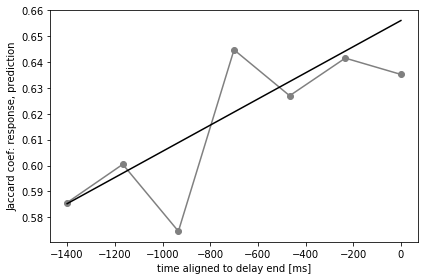

In [277]:
# make linear fit
X = (np.arange(-len(binaryAcc_time),0)*bins)
params = LinearRegression().fit(X.reshape(-1,1), np.array(binaryAcc_time).reshape(-1,1))

plt.figure(figsize=(6,4))
plt.plot(x_acc,binaryAcc_time, color='grey', marker='o')
plt.plot(x_acc, params.coef_[0]*x_acc+params.intercept_[0], color='k')
plt.xlabel('time aligned to delay end [ms]')
plt.ylabel('Jaccard coef: response, prediction')
plt.tight_layout()
#plt.savefig('../Figures/Neural/CWvsCCW/CWvsCCWdecoding_endDelaytime_200msBins_5cutoff.png', dpi=200)
plt.show()

In [ ]:
plt.plot(x_acc,contAcc_time, color='darkred')
plt.xlabel('time until delay end [ms]')
plt.ylabel('MSE')
plt.title('average prediction acc of response')

# CW/CCW over time, separate hemispheres

In [239]:
len(right)

48

In [25]:
# create dataframe with only left neurons (SINGLE trials)
df_Sa0 = df_Sa0.reset_index()
df_Sa0_left = df_Sa0.copy()# ['bin_sp_prev'][0][0][left]
df_Sa0_left.drop(['bin_sp'], axis=1)
df_Sa0_left['bin_sp'] = [[df_Sa0['bin_sp'][n][t][left] for t in range(len(df_Sa0['bin_sp'][n]))] for n in range(len(df_Sa0['bin_sp']))]

# only right neurons (SINGLE trials)
df_Sa0_right = df_Sa0.copy()# ['bin_sp_prev'][0][0][left]
df_Sa0_right.drop(['bin_sp'], axis=1)
df_Sa0_right['bin_sp'] = [[df_Sa0['bin_sp'][n][t][right] for t in range(len(df_Sa0['bin_sp'][n]))] for n in range(len(df_Sa0['bin_sp']))]


decode CW/CCW through left, right hemisphere decoder

In [26]:
y_singleTrial = df_Sa0['targ_angle'].values*np.pi/180-np.pi # convert to radians in [-np.pi, np.pi]
# left hemisphere
pred_error_left, pred_clockw_left, pred_angle_left = decode_response_leave1out_timeTrain(df_Sa0_left,y_singleTrial)


In [27]:
# right hemisphere
pred_error_right, pred_clockw_right, pred_angle_right = decode_response_leave1out_timeTrain(df_Sa0_right,y_singleTrial)


In [28]:
# decode CW/CCW accuracy for left, right hemisphere

cut_off = 0 # trials with error<cut_off are excluded from analysis

binaryAcc_left=[]
contAcc_left=[]
binaryAcc_right=[]
contAcc_right=[]
#contAcc_left_p=[]
for t in range(len(pred_clockw_left[0])):
    pred_cw_left = np.concatenate([pred_clockw_left[n][t] for n in range(len(pred_clockw_left))]) # for one time point, each trial determine predictions
    pred_cw_right = np.concatenate([pred_clockw_right[n][t] for n in range(len(pred_clockw_right))]) # for one time point, each trial determine predictions
    pred_cont_left = np.concatenate([pred_angle_left[n][t] for n in range(len(pred_angle_left))]) # for one time point, each trial determine predictions
    pred_cont_right = np.concatenate([pred_angle_right[n][t] for n in range(len(pred_angle_right))]) # for one time point, each trial determine predictions

    # LEFT: only evaluate where prediction error is larger cut_off value (safer predictions)
    # only use trials where prediction error is larger than cut-off
    err_idx_left = np.where(np.array(np.concatenate([pred_error_left[n][t] for n in df_Sa0_left.index]))*180/np.pi>cut_off)[0]
    # calculate binary accuracy of CW/CCW trials
    binaryAcc_left.append(accuracy_score(df_Sa0_left['clockw'].values[err_idx_left], pred_cw_left[err_idx_left]))
    # calculate continuous accuracy of CW/CCW trials
    contAcc_left.append(np.mean((circdist(df_Sa0_left['saccade_angle'].values[err_idx_left]*np.pi/180, pred_cont_left[err_idx_left])**2)))

    # Right: only evaluate where prediction error is larger cut_off value (safer predictions)
    err_idx_right = np.where(np.array(np.concatenate([pred_error_right[n][t] for n in df_Sa0_right.index]))*180/np.pi>cut_off)[0]
    binaryAcc_right.append(accuracy_score(df_Sa0_right['clockw'].values[err_idx_right], pred_cw_right[err_idx_right]))
    contAcc_right.append(np.mean((circdist(df_Sa0_right['saccade_angle'].values[err_idx_right]*np.pi/180, pred_cont_right[err_idx_right])**2)))
    

plot binary accuracy over time

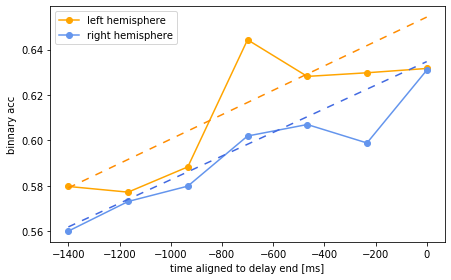

In [111]:
# make linear fit
X = (np.arange(-len(binaryAcc_left),0)*bins)
params_left = LinearRegression().fit(X.reshape(-1,1), np.array(binaryAcc_left).reshape(-1,1))
params_right = LinearRegression().fit(X.reshape(-1,1), np.array(binaryAcc_right).reshape(-1,1))

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(x_acc,binaryAcc_left, color='orange', marker='o', label='left hemisphere')
plt.plot(x_acc,binaryAcc_right, color='cornflowerblue', marker='o', label='right hemisphere')
plt.plot(x_acc, params_left.coef_[0]*x_acc+params_left.intercept_[0], dashes=[5,5], color='darkorange')
plt.plot(x_acc, params_right.coef_[0]*x_acc+params_right.intercept_[0], dashes=[5,5], color='royalblue')
plt.xlabel('time aligned to delay end [ms]')
plt.ylabel('binnary acc')
plt.legend()
plt.tight_layout()
#plt.savefig('../Figures/Neural/CWvsCCW/hemispheres/CWvsCCWdecoding_endDelaytime_200msBins_30cutoff.png', dpi=200)
plt.show()

## Correlation between CW/CCW decoding across hemispheres

scatterplot and linear regression fit of left vs right hemisphere predictions (mean across delay end)

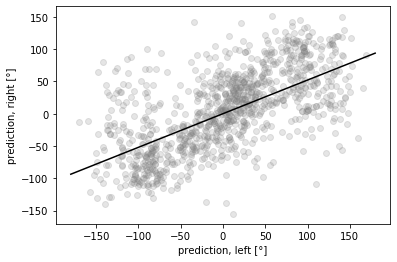

In [158]:
x_ang = np.linspace(-180,180,500)
params = LinearRegression().fit(np.mean(pred_angle_left, axis=1).reshape(-1,1), np.mean(pred_angle_right, axis=1).reshape(-1,1))

plt.figure()
plt.scatter(np.mean(pred_angle_left, axis=1)*180/np.pi, np.mean(pred_angle_right, axis=1)*180/np.pi, color='grey', alpha=0.2)
plt.plot(x_ang, params.coef_[0]*x_ang+params.intercept_[0], color='k')
plt.xlabel('prediction, left [°]')
plt.ylabel('prediction, right [°]')
#plt.savefig('../Figures/Neural/CWvsCCW/hemispheres/CWvsCCWCorrelation_LeftRight.png', dpi=200)
plt.show()

### Constant decoder (delay-decoder)

R² score across time during the delay between hemispheres (how aligned are hemisphere predictions during the delay)

In [97]:
len(np.concatenate(pred_angle_left, axis=1))

7

In [104]:
targ_left_singleTrial = np.where((y_singleTrial>np.pi/2) & (y_singleTrial<np.pi+np.pi/2))[0]
targ_right_singleTrial = np.where((y_singleTrial<np.pi/2) | (y_singleTrial>np.pi+np.pi/2))[0]
response_singleTrial = df_Sa0['saccade_angle'].values*np.pi/180-np.pi

In [105]:
r2_lr=[]# hemisphere correlation
r2_li=[]# correlation left ipsi with target
r2_lc=[]# correlation left contra with target
r2_ri=[]# correlation right ipsi with target
r2_rc=[]# correlation right contra with target
r2_li_res=[]# correlation left ipsi with response
r2_lc_res=[]# correlation left contra with response
r2_ri_res=[]# correlation right ipsi with response
r2_rc_res=[]# correlation right contra with response
for i in range(len(pred_angle_left[0])):
    # between hemispheres
    dat ={'x': np.concatenate(pred_angle_left, axis=1)[i,:], 'y':np.concatenate(pred_angle_right, axis=1)[i,:]}
    mod=sf.ols('y~x',data=dat)
    res=mod.fit()
    r2_lr.append(res.rsquared)
    
    # Compare to target position
    # left, ipsilateral
    dat ={'x': np.concatenate(pred_angle_left, axis=1)[i,targ_left_singleTrial], 'y':y_singleTrial[targ_left_singleTrial]}
    mod=sf.ols('y~x',data=dat)
    res=mod.fit()
    r2_li.append(res.rsquared)
    # left, contralateral
    dat ={'x': np.concatenate(pred_angle_left, axis=1)[i,targ_right_singleTrial], 'y':y_singleTrial[targ_right_singleTrial]}
    mod=sf.ols('y~x',data=dat)
    res=mod.fit()
    r2_lc.append(res.rsquared)
    # right, ipsilateral
    dat ={'x': np.concatenate(pred_angle_right, axis=1)[i,targ_right_singleTrial], 'y':y_singleTrial[targ_right_singleTrial]}
    mod=sf.ols('y~x',data=dat)
    res=mod.fit()
    r2_ri.append(res.rsquared)
    # right, contralateral
    dat ={'x': np.concatenate(pred_angle_right, axis=1)[i,targ_left_singleTrial], 'y':y_singleTrial[targ_left_singleTrial]}
    mod=sf.ols('y~x',data=dat)
    res=mod.fit()
    r2_rc.append(res.rsquared)
    
        
    # Compare to response position
    # left, ipsilateral
    dat ={'x': np.concatenate(pred_angle_left, axis=1)[i,targ_left_singleTrial], 'y':response_singleTrial[targ_left_singleTrial]}
    mod=sf.ols('y~x',data=dat)
    res=mod.fit()
    r2_li_res.append(res.rsquared)
    # left, contralateral
    dat ={'x': np.concatenate(pred_angle_left, axis=1)[i,targ_right_singleTrial], 'y':response_singleTrial[targ_right_singleTrial]}
    mod=sf.ols('y~x',data=dat)
    res=mod.fit()
    r2_lc_res.append(res.rsquared)
    # right, ipsilateral
    dat ={'x': np.concatenate(pred_angle_right, axis=1)[i,targ_right_singleTrial], 'y':response_singleTrial[targ_right_singleTrial]}
    mod=sf.ols('y~x',data=dat)
    res=mod.fit()
    r2_ri_res.append(res.rsquared)
    # right, contralateral
    dat ={'x': np.concatenate(pred_angle_right, axis=1)[i,targ_left_singleTrial], 'y':response_singleTrial[targ_left_singleTrial]}
    mod=sf.ols('y~x',data=dat)
    res=mod.fit()
    r2_rc_res.append(res.rsquared)

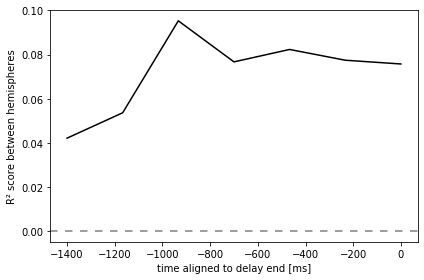

In [106]:
plt.figure(figsize=(6,4))
plt.plot(x_acc,r2_lr, color='k')
plt.axhline(0, dashes=[5,5], color='grey')
plt.xlabel('time aligned to delay end [ms]')
plt.ylabel('R² score between hemispheres')
plt.tight_layout()

#plt.savefig('../Figures/Neural/CWvsCCW/hemispheres/Hemispheres_predictionCorrelation_DelayDecoder.png', dpi=200)
plt.show()

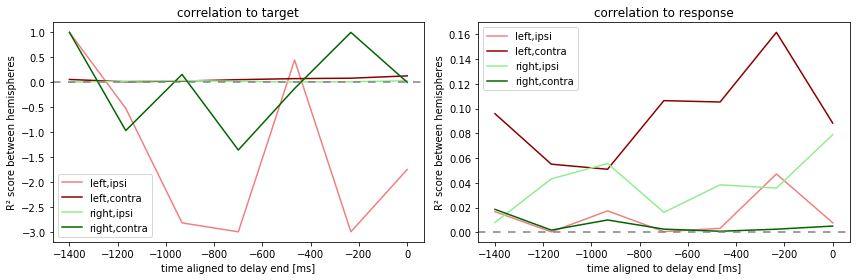

In [107]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(x_acc,r2_li, color='lightcoral', label='left,ipsi')
plt.plot(x_acc,r2_lc, color='darkred', label='left,contra')
plt.plot(x_acc,r2_ri, color='lightgreen', label='right,ipsi')
plt.plot(x_acc,r2_rc, color='darkgreen', label='right,contra')
plt.axhline(0, dashes=[5,5], color='grey')
plt.xlabel('time aligned to delay end [ms]')
plt.ylabel('R² score between hemispheres')
plt.title('correlation to target')
plt.legend()

plt.subplot(122)
plt.plot(x_acc,r2_li_res, color='lightcoral', label='left,ipsi')
plt.plot(x_acc,r2_lc_res, color='darkred', label='left,contra')
plt.plot(x_acc,r2_ri_res, color='lightgreen', label='right,ipsi')
plt.plot(x_acc,r2_rc_res, color='darkgreen', label='right,contra')
plt.axhline(0, dashes=[5,5], color='grey')
plt.xlabel('time aligned to delay end [ms]')
plt.ylabel('R² score between hemispheres')
plt.title('correlation to response')
plt.legend()
plt.tight_layout()

#plt.savefig('../Figures/Neural/CWvsCCW/hemispheres/Hemispheres_predictionCorrelation_DelayDecoder.png', dpi=200)
plt.show()

### Continuous decoder within delay end

In [164]:
def decode_response_leave1out_timeTrainTest(dataframe,y):
    """Leave-1-out crossvalidation on neural data. Response decoding continuous during delay end (train, test vary)
    
    INPUT:      dataframe = pd Dataframe of a single session, all trials
                y         = targets for each trial
                
    OUTPUT:     pred_error = circular distance of predicted response with response for each trial
                pred_sign  = sign of prediction error
    
    """
    pred_error=[]
    pred_clockw=[]
    pred_angle=[]
    
    # Leave one out crossvalidation
    loo = LeaveOneOut()
    for train_idx, test_idx in loo.split(dataframe): 
        # predict during entire delay, varying bins
        pred_error_bin=[]
        pred_clockw_bin=[]
        pred_angle_bin=[]
        for delta_t_train in range(borders_full[3], borders_full[4]):# test during entire delay 

            # create training dataset: columns=neurons, rows=trials for previous/current trials, train during end of delay
            X = pd.DataFrame([dataframe['bin_sp'][n][delta_t_train] for n in dataframe.index])

            X_train = X.loc[train_idx] # training stays constant 
            y_train, y_test = y[train_idx], y[test_idx]

            # determine labels (sine, cosine)
            y_train_cos = np.cos(y_train)
            y_train_sin = np.sin(y_train)

            # make linear regression fit for sin/cosine for prev/current trial
            model_cos = LinearRegression().fit(X_train, y_train_cos)
            model_sin = LinearRegression().fit(X_train, y_train_sin)

            
            X_test = pd.DataFrame(dataframe['bin_sp'][test_idx[0]][delta_t_train])  # only change testing data in time  
            X_test = X_test.transpose()

            # make predictions of models
            preds_cos = model_cos.predict(X_test)
            preds_sin = model_sin.predict(X_test)

            preds = [math.atan2(preds_sin[n],preds_cos[n]) for n in range(len(preds_sin))]

            # distance between prediction, result
            pred_error_bin.append(circdist(preds, y_test))
            pred_clockw_bin.append(['CW' if np.sign(circdist(preds, y_test))[n]>0 else 'CCW' for n in range(len(np.sign(circdist(preds, y_test))))])
            pred_angle_bin.append(preds)
            
        pred_error.append(pred_error_bin)
        pred_clockw.append(pred_clockw_bin)
        pred_angle.append(pred_angle_bin)
    return pred_error, pred_clockw, pred_angle


In [170]:
y = df_Sa0['targ_angle'].values*np.pi/180-np.pi # convert to radians in [-np.pi, np.pi]
# left hemisphere
pred_error_left_cont, pred_clockw_left_cont, pred_angle_left_cont = decode_response_leave1out_timeTrainTest(df_Sa0_left,y)

# right hemisphere
pred_error_right_cont, pred_clockw_right_cont, pred_angle_right_cont = decode_response_leave1out_timeTrainTest(df_Sa0_right,y)


Calculate r² score across left/ right hemisphere over delay time

In [228]:
r2_cont=[]
for i in range(len(pred_angle_left[0])):
    dat ={'x': np.concatenate(pred_angle_left_cont, axis=1)[i,:], 'y':np.concatenate(pred_angle_right_cont, axis=1)[i,:]}
    mod=sf.ols('y~x',data=dat)
    res=mod.fit()
    r2_cont.append(res.rsquared)

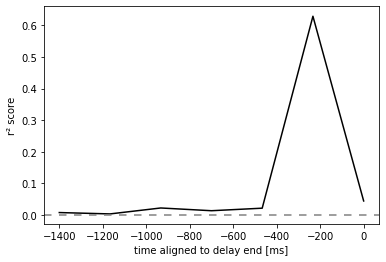

In [271]:
plt.figure(figsize=(6,4))
plt.plot(x_acc,r2_cont, color='k')
plt.axhline(0, dashes=[5,5], color='grey')
plt.xlabel('time aligned to delay end [ms]')
plt.ylabel('r² score')

#plt.savefig('../Figures/Neural/CWvsCCW/hemispheres/Hemispheres_predictionCorrelation_fullDecoder.png', dpi=200)
plt.show()

Scatterplot for single timepoints:

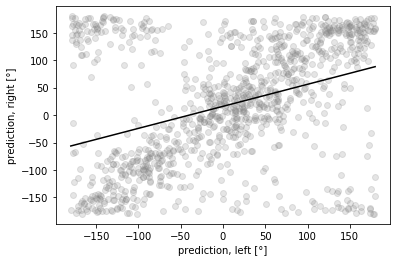

In [209]:
x_ang = np.linspace(-180,180,500)
delay_time=6
params = LinearRegression().fit((np.concatenate(pred_angle_left_cont, axis=1)[delay_time,:]*180/np.pi).reshape(-1,1), (np.concatenate(pred_angle_right_cont, axis=1)[delay_time,:]*180/np.pi).reshape(-1,1))

plt.figure()
plt.scatter(np.concatenate(pred_angle_left_cont, axis=1)[delay_time,:]*180/np.pi, np.concatenate(pred_angle_right_cont, axis=1)[delay_time,:]*180/np.pi, color='grey', alpha=0.2)
plt.plot(x_ang, params.coef_[0]*x_ang+params.intercept_[0], color='k')
plt.xlabel('prediction, left [°]')
plt.ylabel('prediction, right [°]')
#plt.savefig('../Figures/Neural/CWvsCCW/hemispheres/CWvsCCWCorrelation_LeftRight.png', dpi=200)
plt.show()



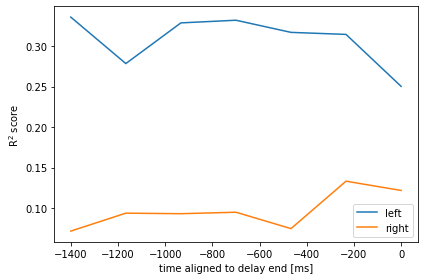

In [273]:
r2_left=[]
r2_right=[]
for i in range(len(pred_angle_left[0])):
    dat ={'x': df_Sa0['saccade_angle'].values, 'y':np.concatenate(pred_angle_left_cont, axis=1)[i,:]}
    mod=sf.ols('y~x',data=dat)
    res=mod.fit()
    r2_left.append(res.rsquared)
    
    dat ={'x': df_Sa0['saccade_angle'].values, 'y':np.concatenate(pred_angle_right_cont, axis=1)[i,:]}
    mod=sf.ols('y~x',data=dat)
    res=mod.fit()
    r2_right.append(res.rsquared)

plt.figure()
plt.plot(x_acc, r2_left, label='left')
plt.plot(x_acc, r2_right, label='right')
plt.xlabel('time aligned to delay end [ms]')
plt.ylabel('R$^2$ score')
plt.legend()
plt.tight_layout()
#plt.savefig('../Figures/Neural/CWvsCCW/hemispheres/Hemispheres_predictionCorrelationAgainstResponse_fullDecoder.png', dpi=200)
plt.show()

## Analysis ipsi vs contralateral trials

In [218]:
len(left_ipsi)

7

In [212]:
left_ipsi = np.concatenate(pred_angle_left_cont, axis=1)[:,targ_left]
left_contra = np.concatenate(pred_angle_left_cont, axis=1)[:,targ_right]
right_ipsi = np.concatenate(pred_angle_right_cont, axis=1)[:,targ_left]
right_contra = np.concatenate(pred_angle_right_cont, axis=1)[:,targ_right]

In [219]:
r2_left_ipsi=[]
r2_left_contra=[]
r2_right_ipsi=[]
r2_right_contra=[]
for i in range(len(left_ipsi)):
    dat ={'x': df_Sa0['saccade_angle'].values[targ_left], 'y':left_ipsi[i]}
    mod=sf.ols('y~x',data=dat)
    res=mod.fit()
    r2_left_ipsi.append(res.rsquared)
    
    dat ={'x': df_Sa0['saccade_angle'].values[targ_right], 'y':left_contra[i]}
    mod=sf.ols('y~x',data=dat)
    res=mod.fit()
    r2_left_contra.append(res.rsquared)
    
    dat ={'x': df_Sa0['saccade_angle'].values[targ_right], 'y':right_ipsi[i]}
    mod=sf.ols('y~x',data=dat)
    res=mod.fit()
    r2_right_ipsi.append(res.rsquared)
    
    dat ={'x': df_Sa0['saccade_angle'].values[targ_left], 'y':right_contra[i]}
    mod=sf.ols('y~x',data=dat)
    res=mod.fit()
    r2_right_contra.append(res.rsquared)

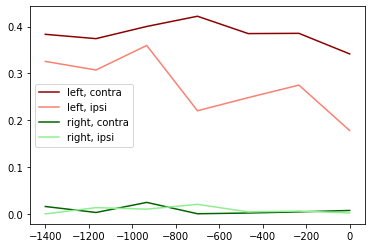

In [227]:
plt.figure()
plt.plot(x_acc, r2_left_contra, color='darkred',label='left, contra')
plt.plot(x_acc, r2_left_ipsi, color='salmon',label='left, ipsi')
plt.plot(x_acc, r2_right_contra,color='darkgreen', label='right, contra')
plt.plot(x_acc, r2_right_ipsi,color='lightgreen', label='right, ipsi')
plt.legend()